# Normative model 


In this script we perform the normative model on the ABIDE dataset where TC are the train set and ASD the test set. We included 10% of the TC in the test set. We used the Destrieux atlas for the ROIs. The deviation scores and plots are saved in the results folder. This script is for the subcortical structures specifically

## Import all packages

In [91]:
import os
import csv
import numpy as np
import pandas as pd
import pickle
import chardet
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
import matplotlib.image as mpimg
from scipy.stats import linregress
import random as rd 
from random import uniform, random, choice, sample
from sklearn.model_selection import train_test_split
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
import pcntoolkit.dataio.fileio as fileio
from nilearn import plotting
import nibabel as nib
from nilearn import datasets



## Define variables needed for the model

### Specify algorithm

In [92]:
algo = 'blr'
optimizer = 'powell'
seed = 0

### Set directories

In [93]:
#Set to correct working directory
os.chdir('/Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol')

# where the analysis takes place
root_dir = os.path.dirname(os.getcwd())

folder_dir = os.path.join(root_dir, 'ASD_model_subvol')

# where the raw data are stored
data_dir = os.path.join(root_dir, 'data')

# where the results are saved
result_dir = os.path.join(folder_dir, 'results')

#Save brain plots
brainplot_dir = os.path.join(result_dir, 'Brainmaps')
statsplot_dir = os.path.join(brainplot_dir, 'Statplots')

# when testing for control group
out_dir = os.path.join(os.path.join(result_dir, algo), optimizer)

# create the output directory if it does not already exist
os.makedirs(out_dir, exist_ok=True)
os.makedirs(os.path.join(out_dir, 'outputs'), exist_ok=True)

os.makedirs(brainplot_dir, exist_ok=True)
os.makedirs(os.path.join(out_dir, 'Brainmaps'), exist_ok=True)

os.makedirs(statsplot_dir, exist_ok=True)
os.makedirs(os.path.join(out_dir, 'Statplots'), exist_ok=True)


## Load data

We prepared in R one big csv file with all data. Bad quality data is already excluded.

In [94]:
all_data = pd.read_csv('Data/Data_normative_subvol.txt')

The site_IDs are called differently for ABIDE2 but this can cause problems in the model. Therefore we have to rename these to the short site IDs. 

In [95]:

# Create a mapping of the old names to the new names
name_mapping = {
    'ABIDEII-KKI_1': 'MERGED_KKI',
    'ABIDEII-NYU_1': 'MERGED_NYU',
    'ABIDEII-SDSU_1': 'MERGED_SDSU',
    'ABIDEII-UCLA_1': 'MERGED_UCLA_1',
    'KKI': 'MERGED_KKI',
    'NYU': 'MERGED_NYU',
    'SDSU': 'MERGED_SDSU',
    'UCLA_1': 'MERGED_UCLA_1'
}

# Replace the names in the 'SITE_ID' column using the mapping
all_data['SITE_ID'] = all_data['SITE_ID'].replace(name_mapping)

In [96]:
# Create a list of all the ROIs 
roi_ids = np.array(all_data.columns[7:-3])
roi_ids_cortical = np.array(all_data.columns[7:-24])

# Remove any subjects that have NaN variables in any of the columns
all_data.dropna(inplace=True)


## Split in train and test

We use a split based on diagnosis. ASD will be the test set and TC will be the training set. However, we will also add 10% of the TC to the training set

We remove all sites with n lower than 10 in each diagnostic group.


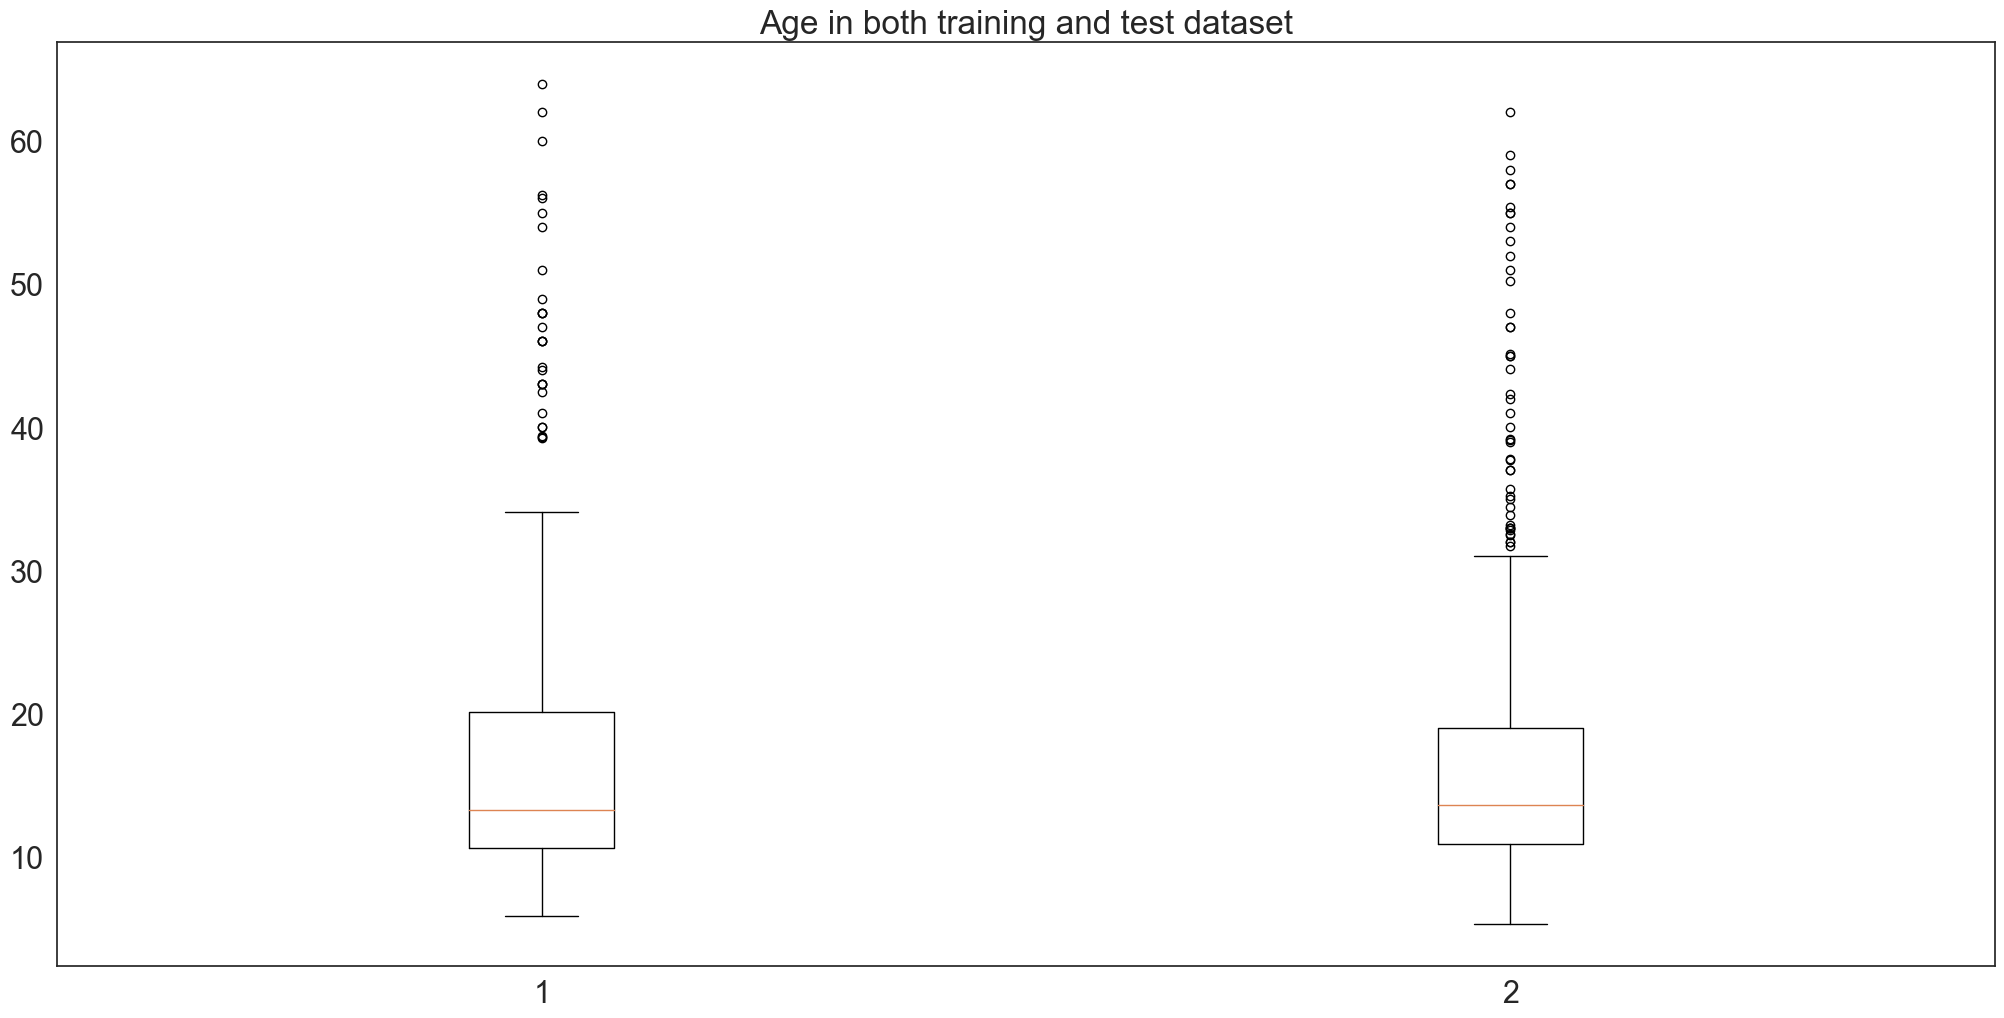

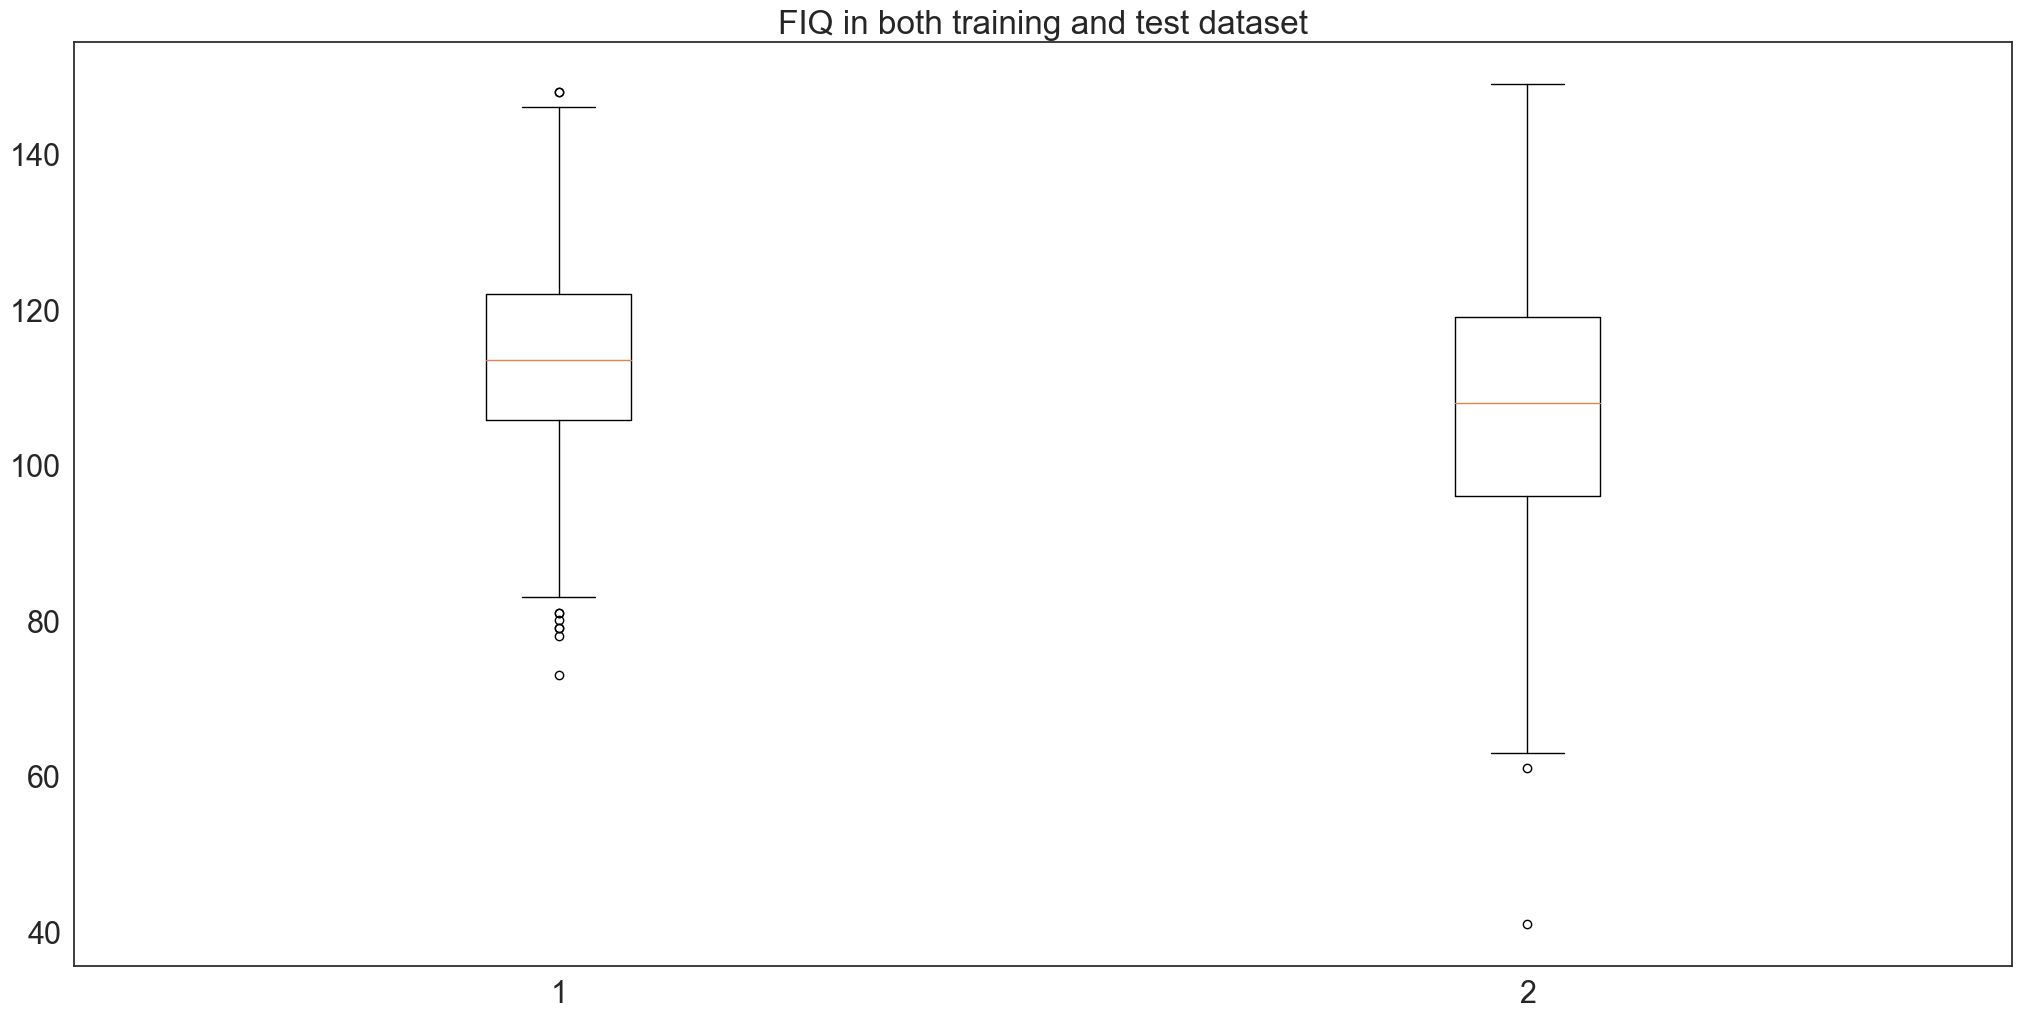

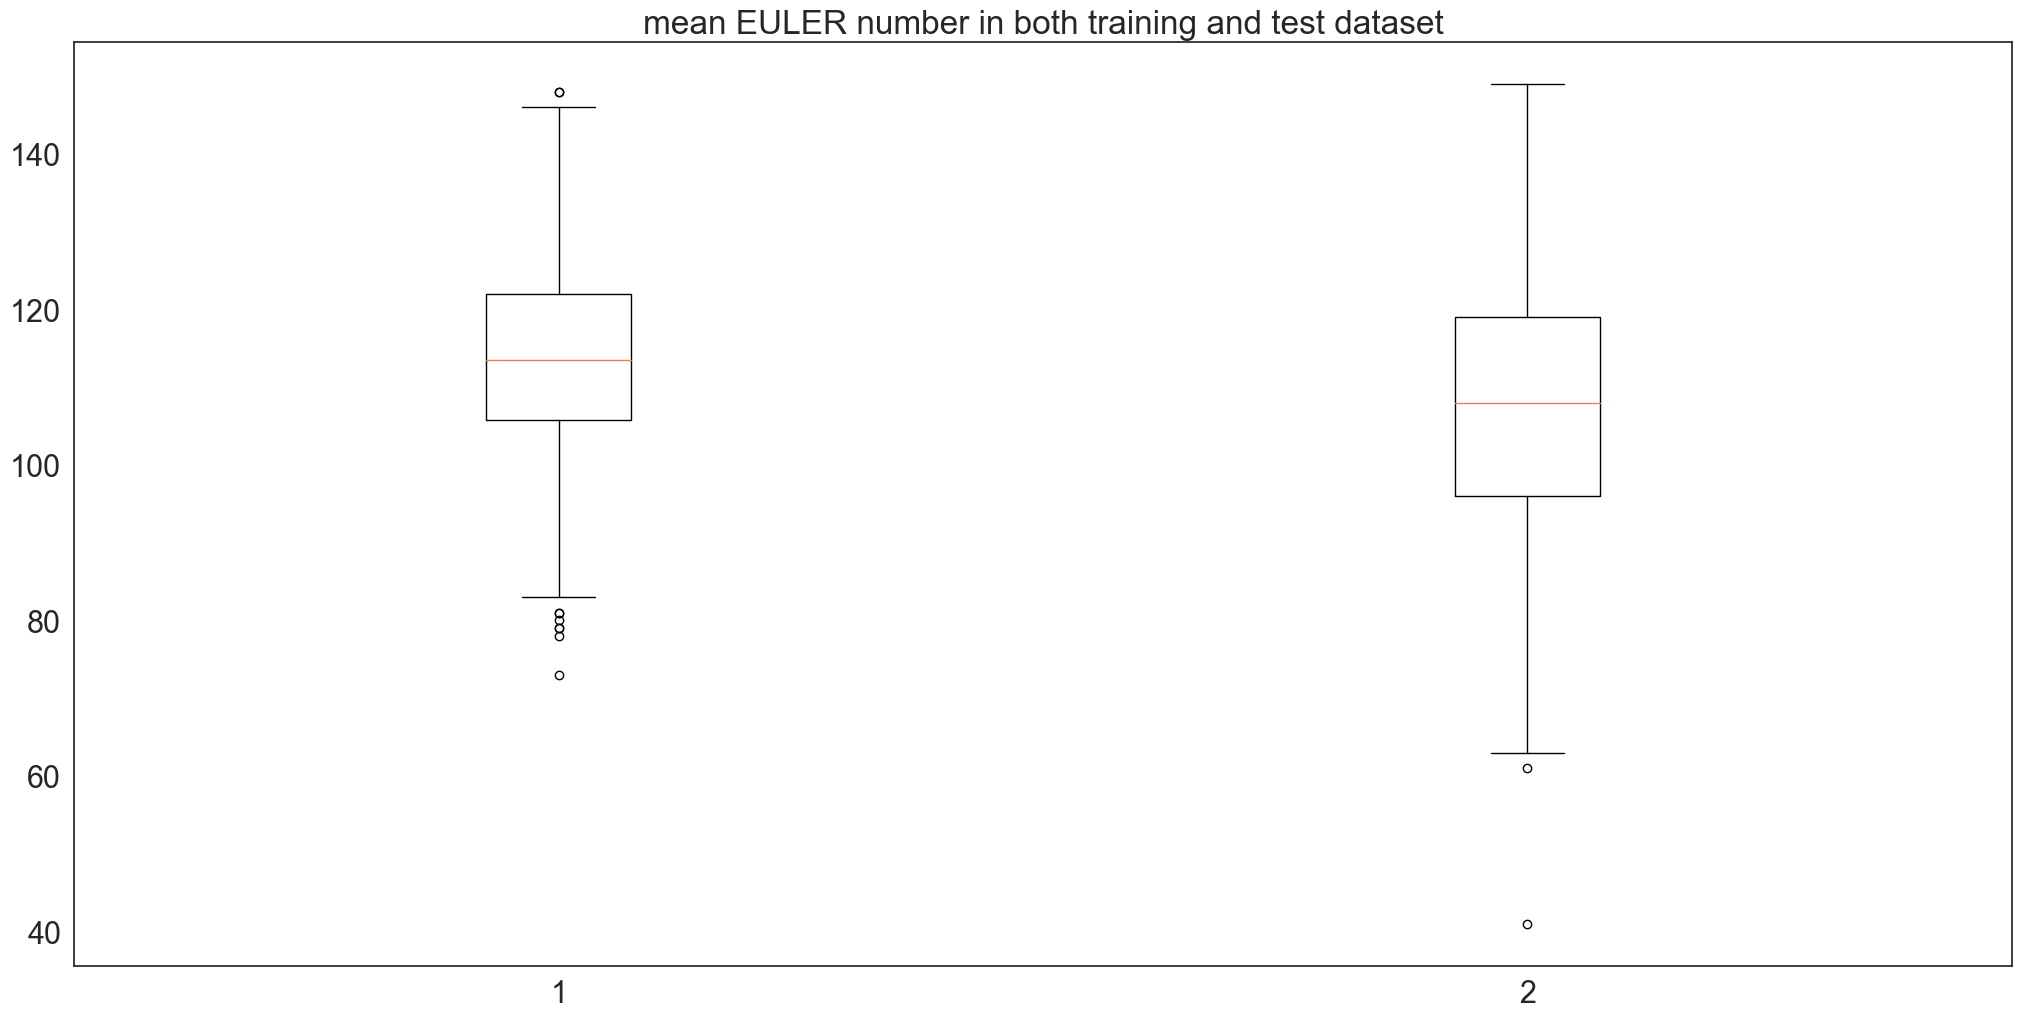

23

In [99]:
# Remove all participants from KUL and SBL

all_data = all_data.drop(all_data[(all_data.SITE_ID == 'ABIDEII-KUL_3') | (all_data.SITE_ID == 'SBL') | (all_data.SITE_ID == 'ABIDEII-IP_1') | (all_data.SITE_ID == 'MERGED_SDSU') | (all_data.SITE_ID == 'ABIDEII-NYU_2')].index)


#First split into ASD and TC
all_data_ASD = all_data[(all_data.DX_GROUP==1)]
all_data_TC = all_data[(all_data.DX_GROUP==2)]

# Split into covariates and brain
df_brainfeatures_ASD = all_data_ASD[roi_ids]
df_brainfeatures_TC = all_data_TC[roi_ids]

df_covariates_ASD = all_data_ASD[['AGE_AT_SCAN', 'FIQ', 'SITE_ID', 'meanEULER', 'EstimatedTotalIntraCranialVol']]
df_covariates_TC = all_data_TC[['SUB_ID','AGE_AT_SCAN', 'FIQ', 'SITE_ID', 'meanEULER', 'EstimatedTotalIntraCranialVol']] #We include SUB_ID for now because we want to have this information in later steps. However, remove this after splitting in test and train. 

#Also make a dataframe with both test and train but only features of covariates
df_brainfeatures = all_data[roi_ids]
df_covariates = all_data[['AGE_AT_SCAN', 'FIQ', 'SITE_ID','meanEULER', 'EstimatedTotalIntraCranialVol']]


# Split TC set into train and test with 10% in test
train_covariates_TC, test_covariates_TC,train_brainfeatures_TC, test_brainfeatures_TC = train_test_split(df_covariates_TC, df_brainfeatures_TC, test_size=0.1, random_state=43)

#Rename data so it matches normative model code
df_brainfeatures_train = train_brainfeatures_TC
df_covariates_train = train_covariates_TC[['AGE_AT_SCAN', 'FIQ', 'SITE_ID', 'meanEULER', 'EstimatedTotalIntraCranialVol']]

#Add the randomly selected TC to the ASD to create the test dataset
df_brainfeatures_test = pd.concat([df_brainfeatures_ASD,test_brainfeatures_TC])
df_covariates_test = pd.concat([df_covariates_ASD, test_covariates_TC[['AGE_AT_SCAN', 'FIQ', 'SITE_ID', 'meanEULER', 'EstimatedTotalIntraCranialVol']]])

df_covariates_testTC = test_covariates_TC[['AGE_AT_SCAN', 'FIQ', 'SITE_ID', 'meanEULER', 'EstimatedTotalIntraCranialVol']]
df_brainfeatures_testTC = test_brainfeatures_TC

#Plots
plot_data_age = [df_covariates_train['AGE_AT_SCAN'], df_covariates_test['AGE_AT_SCAN']]
plt.boxplot(plot_data_age)
plt.title('Age in both training and test dataset')
plt.show()

plot_data_FIQ = [df_covariates_train['FIQ'], df_covariates_test['FIQ']]
plt.boxplot(plot_data_FIQ)
plt.title('FIQ in both training and test dataset')
plt.show()

plot_data_euler = [df_covariates_train['meanEULER'], df_covariates_test['meanEULER']]
plt.boxplot(plot_data_FIQ)
plt.title('mean EULER number in both training and test dataset')
plt.show()


display(len(np.unique(df_covariates_testTC['SITE_ID'])))

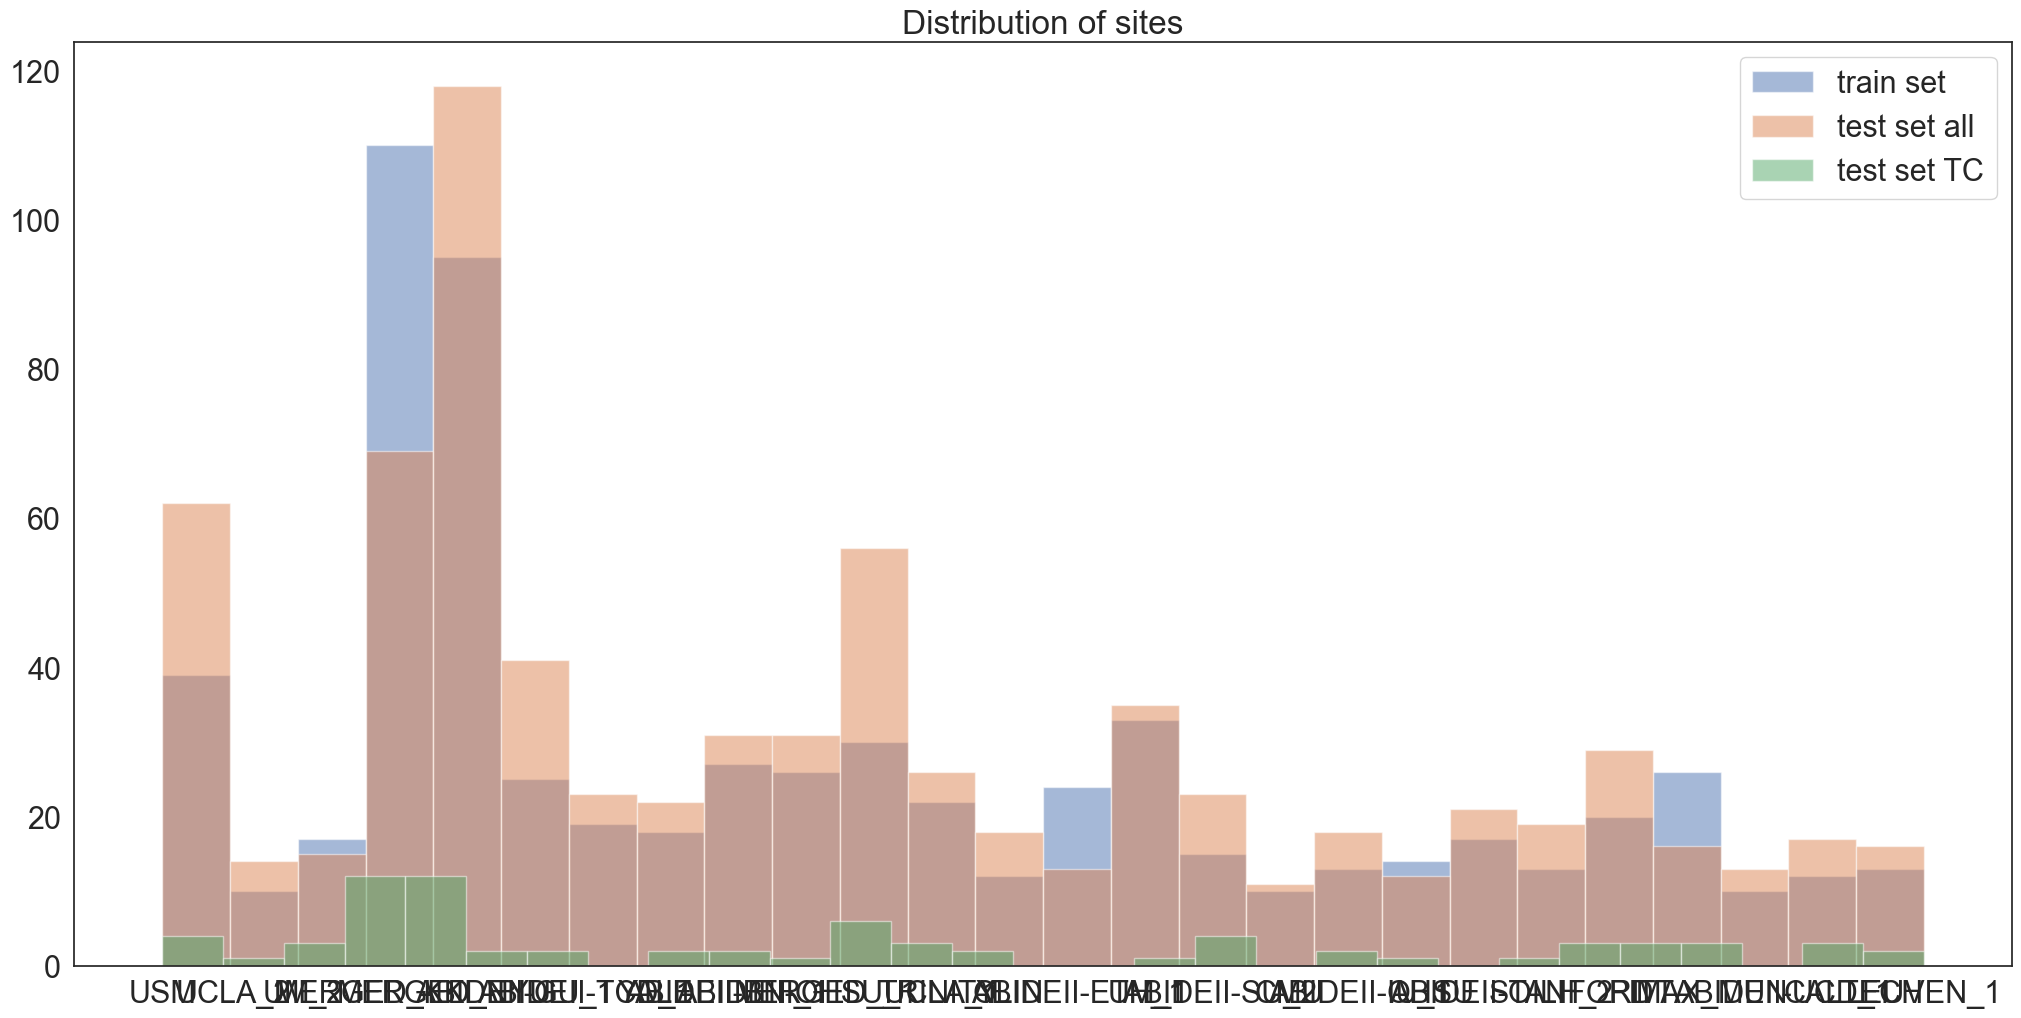

In [100]:
# The distribution of the split
plt.rc('figure', figsize=(25, 12))

plt.hist(df_covariates_train['SITE_ID'], alpha=0.5, label='train set',bins=len(np.unique(df_covariates_train['SITE_ID'])))
plt.hist(df_covariates_test['SITE_ID'], alpha=0.5, label = 'test set all', bins=len(np.unique(df_covariates_test['SITE_ID'])))
plt.hist(df_covariates_testTC['SITE_ID'], alpha=0.5, label='test set TC', bins=29)
plt.legend()
plt.title('Distribution of sites')
plt.show()

## 6. Set parameters in a variable

cols_cov: Which covariates used for the model (besides site, this is handeled seperately)

Xmin and xmax are the minimum and maximum age ranges in the data. This age range matches the age range of the participants in this study. 

Basis: bspline: this is in what way we do the non linearity

Site_ids: a list of all sites 

algo: which algorithm used. We use a Bayesian Linear Regression (BLR)

optimizer: We use Powell optimisation

warp: Sets which warping algorithm. We use WarpSinArchinh

out_dir: variable that defines the output directory

nknots: how many knots in the bsplite are used. The default is 5 but we use 3 since this leads to a bit less free result that matches better. Less overfitting.


In [102]:
params = {  'cols_cov' : ['AGE_AT_SCAN', 'FIQ', 'meanEULER', 'EstimatedTotalIntraCranialVol'],
            'xmin' : 5,
            'xmax' : 64,
            'basis' : 'bspline',
            'site_ids' : list(all_data.SITE_ID.unique()),
            'algo' : algo,
            'optimizer' : optimizer,  
            'warp' : 'WarpSinArcsinh',
            'out_dir' : out_dir, 
            'nknots' : 3 #Default is 5
         }

suffix = 'estimate'



## 8. Fit normative model

In [103]:
for idp_num, idp in enumerate(roi_ids): # loop through all ROIs
    
    # Set output dir for the current ROI
    idp_dir = os.path.join(params['out_dir'], idp)
    os.makedirs(os.path.join(idp_dir), exist_ok=True)
    os.chdir(idp_dir)
    
    #Extract the response variables corresponding to the current ROI for training and test set
    y_tr = df_brainfeatures_train[idp].to_numpy()
    y_te = df_brainfeatures_test[idp].to_numpy()
    y_te_TC = df_brainfeatures_testTC[idp].to_numpy()
    
    
    #Write out the response variables for training and test
    resp_file_tr = os.path.join(idp_dir, 'resp_tr.txt')
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt')
    resp_file_te_TC = os.path.join(idp_dir,'resp_te_TC.txt')
    np.savetxt(resp_file_tr, y_tr)
    np.savetxt(resp_file_te, y_te)
    np.savetxt(resp_file_te_TC, y_te_TC)
    
    #Configure the design matrix
    X_tr = create_design_matrix(df_covariates_train[params['cols_cov']],
                                site_ids = df_covariates_train['SITE_ID'],
                                basis = params['basis'], 
                                xmin = params['xmin'], 
                                xmax = params['xmax'],
                                nknots = params['nknots'])
    
    X_te = create_design_matrix(df_covariates_test[params['cols_cov']],
                                site_ids = df_covariates_test['SITE_ID'], 
                                all_sites=params['site_ids'],
                                basis = params['basis'], 
                                xmin = params['xmin'], 
                                xmax = params['xmax'],
                                nknots = params['nknots'])
    
    X_te_TC = create_design_matrix(df_covariates_testTC[params['cols_cov']],
                                site_ids = df_covariates_testTC['SITE_ID'], 
                                all_sites=params['site_ids'],
                                basis = params['basis'], 
                                xmin = params['xmin'], 
                                xmax = params['xmax'],
                                nknots = params['nknots'])
    
    #Configure and save the design matrix of the covariates
    cov_file_tr = os.path.join(idp_dir, 'cov_bspline_tr.txt')
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    cov_file_te_TC = os.path.join(idp_dir, 'cov_bspline_te_TC.txt')
    np.savetxt(cov_file_tr, X_tr)
    np.savetxt(cov_file_te, X_te)
    np.savetxt(cov_file_te_TC, X_te_TC)

    
    #Estimate model
    estimate(cov_file_tr, resp_file_tr, testresp=resp_file_te, testcov = cov_file_te,
             alg=params['algo'], optimizer = params['optimizer'], savemodel = True,
             warp = params['warp'], warp_reparam=True, outputsuffix = suffix)

    #Estimate with only TC as test to see how the model performs outside of diagnosis
    yhat_te_TC, s2_te_TC, Z_TC = predict(cov_file_te_TC,
                                         alg='blr',
                                         respfile = resp_file_te_TC,
                                         model_path = os.path.join(idp_dir, 'Models'),
                                         warp = params['warp'], warp_reparam=True)
    
    
    #Configure and save the estimate values
    yhat_te_TC_file = os.path.join(idp_dir, 'yhat_te_TC.txt')
    s2_te_TC_file = os.path.join(idp_dir, 's2_te_TC.txt')
    Z_TC_file = os.path.join(idp_dir, 'Z_TC.txt')
    np.savetxt(yhat_te_TC_file, yhat_te_TC)
    np.savetxt(s2_te_TC_file, s2_te_TC)
    np.savetxt(Z_TC_file, Z_TC)


Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Left.Cerebellum.White.Matter/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.9668e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 6306.115621
         Iterations: 2
         Function evaluations: 126
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Left.Cerebellum.Cortex/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.73392e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 6999.179181
         Iterations: 2
         Function evaluations: 116
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Left.Thalamus/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.75944e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 5429.939230
         Iterations: 2
         Function evaluations: 120
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Left.Caudate/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.48867e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.53548e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.06379e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.68026e-17): result may not be accurate.
  invAXt = linalg

Optimization terminated successfully.
         Current function value: 5097.547428
         Iterations: 3
         Function evaluations: 159
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Left.Putamen/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.35425e-28): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.87069e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.77867e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.77913e-17): result may not be accurate.
  invAXt = linalg

Optimization terminated successfully.
         Current function value: 5227.978550
         Iterations: 3
         Function evaluations: 159
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Left.Pallidum/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.3023e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 4676.051767
         Iterations: 2
         Function evaluations: 114
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Brain.Stem/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.91596e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.2094e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.06103e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 6111.005864
         Iterations: 3
         Function evaluations: 167
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Left.Hippocampus/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.77531e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.38071e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.30881e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 4997.252918
         Iterations: 3
         Function evaluations: 158
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Left.Amygdala/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.89724e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 4634.565246
         Iterations: 2
         Function evaluations: 113
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Left.Accumbens.area/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.08829e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.94884e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.87228e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 4152.632884
         Iterations: 3
         Function evaluations: 165
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Left.VentralDC/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.42454e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.16608e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.09812e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 4933.619658
         Iterations: 3
         Function evaluations: 162
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Right.Cerebellum.White.Matter/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.83217e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 6282.026167
         Iterations: 2
         Function evaluations: 118
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Right.Cerebellum.Cortex/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.82788e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 6999.145320
         Iterations: 2
         Function evaluations: 116
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Right.Thalamus/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.56813e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 5406.606112
         Iterations: 2
         Function evaluations: 119
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Right.Caudate/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.83227e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.68175e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 5103.137040
         Iterations: 3
         Function evaluations: 164
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Right.Putamen/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.00504e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.32842e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.95693e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.00917e-16): result may not be accurate.
  invAXt = linalg

Optimization terminated successfully.
         Current function value: 5179.092262
         Iterations: 3
         Function evaluations: 160
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Right.Pallidum/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.74629e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 4654.513215
         Iterations: 2
         Function evaluations: 114
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Right.Hippocampus/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.8089e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.90663e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.83033e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.84629e-17): result may not be accurate.
  invAXt = linalg.

Optimization terminated successfully.
         Current function value: 4996.702727
         Iterations: 3
         Function evaluations: 158
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Right.Amygdala/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.0989e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 4649.220805
         Iterations: 2
         Function evaluations: 113
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Right.Accumbens.area/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.34e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.14265e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.57245e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.50801e-17): result may not be accurate.
  invAXt = linalg.so

Optimization terminated successfully.
         Current function value: 4131.536043
         Iterations: 3
         Function evaluations: 164
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Right.VentralDC/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.51935e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.1711e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.10438e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 4950.275351
         Iterations: 3
         Function evaluations: 160
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Left.Striatum/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.00339e-16): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.23404e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.10359e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: 5495.252502
         Iterations: 3
         Function evaluations: 166
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Processing data in /Volumes/methlab/Students/Jente/Scripts_ASD_paper/python_scripts/ASD_model_subvol/results/blr/powell/Right.Striatum/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0301e-16): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.58818e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.78688e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/jentemeijer/anaconda3/envs/normative_modelling/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.19723e-17): result may not be accurate.
  invAXt = linalg.

Optimization terminated successfully.
         Current function value: 5470.055827
         Iterations: 3
         Function evaluations: 164
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...


## 9. Evaluate model

In [104]:
# Use a function to load the data since PCNtoolkit needs a specific format. Lets load this function
def load_2d(filename):
    """ this simple function loads a data type supported by PCNtoolkit and
        ensures that the output is a 2d numpy array
    """
    
    x = fileio.load(filename)
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    
    return x



# Make empty dataframe to store all evaluation variables
blr_metrics = pd.DataFrame(columns=['eid','NLL','EV','MSLL','SMSE','BIC','Rho','pRho'])

for idp_num, idp in enumerate(roi_ids): #Loop through all ROIs
    
    # Set path to folder of ROI
    idp_dir = os.path.join(out_dir, idp)
    
    #Load predictions and true data
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_' + suffix + '.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_' + suffix + '.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_' + 'te' + '.txt'))
    y_tr = load_2d(os.path.join(idp_dir, 'resp_' + 'tr' + '.txt'))
    
    #Load model
    with open(os.path.join(idp_dir,'Models','NM_0_0_' + suffix + '.pkl'),'rb') as handle:
        nm = pickle.load(handle)
        
    # Compute error metrics
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
    W = nm.blr.warp
            
    ## warp predictions
    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
    med_te = med_te[:, np.newaxis]

    ## evaluation metrics
    metrics = evaluate(y_te, med_te)

    ## compute MSLL manually
    y_val_w = W.f(y_te, warp_param)
    y_tr_w = W.f(y_tr, warp_param)
    y_tr_mean = np.array( [[np.mean(y_tr_w)]] )
    y_tr_var = np.array( [[np.var(y_tr_w)]] )
    MSLL = compute_MSLL(y_val_w, yhat_te, s2_te, y_tr_mean, y_tr_var)

    Z = np.loadtxt(os.path.join(idp_dir, 'Z_' + suffix + '.txt'))
        
    n = np.shape(Z)[0]
    m1 = np.mean(Z)
    m2 = sum((Z-m1)**2)
    m3 = sum((Z-m1)**3)
    m4 = sum((Z-m1)**4)
    s1 = np.std(Z)
    skew = n*m3/(n-1)/(n-2)/s1**3
    sdskew = np.sqrt( 6*n*(n-1) / ((n-2)*(n+1)*(n+3)) )
    kurtosis = (n*(n+1)*m4 - 3*m2**2*(n-1)) / ((n-1)*(n-2)*(n-3)*s1**4)
    sdkurtosis = np.sqrt( 4*(n**2-1) * sdskew**2 / ((n-3)*(n+5)) )
    semean = np.sqrt(np.var(Z)/n)
    sesd = s1/np.sqrt(2*(n-1))
        
    BIC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik
        
    blr_metrics.loc[len(blr_metrics)] = [idp, nm.neg_log_lik, metrics['EXPV'][0], 
                                            MSLL[0], metrics['SMSE'][0], BIC, 
                                            metrics['Rho'][0], metrics['pRho'][0]]

    
#Display and save metrics
display(blr_metrics)
blr_metrics.to_csv(os.path.join(out_dir,'outputs','blr_metrics.csv'))



eid          NLL        EV      MSLL      SMSE  \
0    Left.Cerebellum.White.Matter  6306.115621  0.164606 -0.093179  0.835435   
1          Left.Cerebellum.Cortex  6999.179181  0.069452 -0.033413  0.936743   
2                   Left.Thalamus  5429.939230  0.338758 -0.201488  0.677413   
3                    Left.Caudate  5097.547428  0.201025 -0.105241  0.819551   
4                    Left.Putamen  5227.978550  0.078452 -0.008960  0.930121   
5                   Left.Pallidum  4676.051767  0.205294 -0.098895  0.846298   
6                      Brain.Stem  6111.005864  0.272108 -0.099481  0.743658   
7                Left.Hippocampus  4997.252918  0.132566 -0.014656  0.873317   
8                   Left.Amygdala  4634.565246  0.285586 -0.166714  0.726168   
9             Left.Accumbens.area  4152.632884 -0.172892  0.223271  1.180108   
10                 Left.VentralDC  4933.619658  0.194163 -0.051476  0.807162   
11  Right.Cerebellum.White.Matter  6282.026167  0.159922 -0.088642  0.843041   
12        Right.Cerebellum.Cortex  6999.145320  0.111644 -0.059841  0.890049   
13                 Right.Thalamus  5406.606112  0.317727 -0.183155  0.704054   
14                  Right.Caudate  5103.137040  0.190448 -0.095502  0.825958   
15                  Right.Putamen  5179.092262  0.101475  0.001689  0.908282   
16                 Right.Pallidum  4654.513215  0.228342 -0.115646  0.806545   
17              Right.Hippocampus  4996.702727  0.146054 -0.016269  0.859294   
18                 Right.Amygdala  4649.220805  0.296144 -0.170684  0.714416   
19           Right.Accumbens.area  4131.536043 -0.177391  0.146838  1.177401   
20                Right.VentralDC  4950.275351  0.136551 -0.008699  0.864609   
21                  Left.Striatum  5495.252502  0.187422 -0.074514  0.826168   
22                 Right.Striatum  5470.055827  0.210485 -0.069294  0.802333   

             BIC       Rho          pRho  
0   12638.260352  0.424595  4.211363e-36  
1   14024.387472  0.418105  6.480362e-35  
2   10885.907571  0.617650  1.218738e-88  
3   10221.123967  0.471294  1.550656e-45  
4   10481.986211  0.413561  4.225821e-34  
5    9378.132645  0.495960  3.235447e-51  
6   12248.040840  0.554323  5.905568e-67  
7   10020.534947  0.474333  3.298568e-46  
8    9295.159602  0.550053  1.110791e-65  
9    8331.294878  0.267348  3.361975e-14  
10   9893.268427  0.515397  4.470036e-56  
11  12590.081445  0.420265  2.628123e-35  
12  14024.319752  0.440151  4.576130e-39  
13  10839.241336  0.614339  2.313801e-87  
14  10232.303192  0.474500  3.027961e-46  
15  10384.213636  0.438925  7.949405e-39  
16   9335.055541  0.511045  5.878860e-55  
17  10019.434566  0.479217  2.644091e-47  
18   9324.470721  0.564623  4.056354e-70  
19   8289.101197  0.272702  9.678872e-15  
20   9926.579812  0.493200  1.485190e-50  
21  11016.534114  0.500246  2.942044e-52  
22  10966.140766  0.522947  4.619881e-58

Do this same evaluation but for the TC test set alone

In [105]:
# Use a function to load the data since PCNtoolkit needs a specific format. Lets load this function
def load_2d(filename):
    """ this simple function loads a data type supported by PCNtoolkit and
        ensures that the output is a 2d numpy array
    """
    
    x = fileio.load(filename)
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    
    return x



# Make empty dataframe to store all evaluation variables
blr_metrics_TC = pd.DataFrame(columns=['eid','NLL','EV','MSLL','SMSE','BIC','Rho','pRho'])

for idp_num, idp in enumerate(roi_ids): #Loop through all ROIs
    
    # Set path to folder of ROI
    idp_dir = os.path.join(out_dir, idp)
    
    #Load predictions and true data
    yhat_te_TC = load_2d(os.path.join(idp_dir, 'yhat_te_TC' + '.txt'))
    s2_te_TC = load_2d(os.path.join(idp_dir, 's2_te_TC' +'.txt'))
    y_te_TC = load_2d(os.path.join(idp_dir, 'resp_' + 'te_TC' + '.txt'))
    y_tr = load_2d(os.path.join(idp_dir, 'resp_' + 'tr' + '.txt'))
    
    #Load model
    with open(os.path.join(idp_dir,'Models','NM_0_0_' + suffix + '.pkl'),'rb') as handle:
        nm = pickle.load(handle)
        
    # Compute error metrics
    warp_param_TC = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
    W_TC = nm.blr.warp
            
    ## warp predictions
    med_te_TC = W_TC.warp_predictions(np.squeeze(yhat_te_TC), np.squeeze(s2_te_TC), warp_param_TC)[0]
    med_te_TC = med_te_TC[:, np.newaxis]

    ## evaluation metrics
    metrics_TC = evaluate(y_te_TC, med_te_TC)

    ## compute MSLL manually
    y_val_w = W_TC.f(y_te_TC, warp_param_TC)
    y_tr_w = W_TC.f(y_tr, warp_param_TC)
    y_tr_mean = np.array( [[np.mean(y_tr_w)]] )
    y_tr_var = np.array( [[np.var(y_tr_w)]] )
    MSLL_TC = compute_MSLL(y_val_w, yhat_te_TC, s2_te_TC, y_tr_mean, y_tr_var)
    
    Z = np.loadtxt(os.path.join(idp_dir, 'Z_TC' + '.txt'))

    n_TC = np.shape(Z_TC)[0]
    m1_TC = np.mean(Z_TC)
    m2_TC = sum((Z_TC-m1_TC)**2)
    m3_TC = sum((Z_TC-m1_TC)**3)
    m4_TC = sum((Z_TC-m1_TC)**4)
    s1_TC = np.std(Z_TC)
    skew_TC = n_TC*m3_TC/(n_TC-1)/(n_TC-2)/s1_TC**3
    sdskew_TC = np.sqrt( 6*n_TC*(n_TC-1) / ((n_TC-2)*(n_TC+1)*(n_TC+3)) )
    kurtosis_TC = (n_TC*(n_TC+1)*m4_TC - 3*m2_TC**2*(n_TC-1)) / ((n_TC-1)*(n_TC-2)*(n_TC-3)*s1_TC**4)
    sdkurtosis_TC = np.sqrt( 4*(n_TC**2-1) * sdskew_TC**2 / ((n_TC-3)*(n_TC+5)) )
    semean_TC = np.sqrt(np.var(Z_TC)/n_TC)
    sesd_TC = s1_TC/np.sqrt(2*(n_TC-1))
        
    BIC_TC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik
        
    blr_metrics_TC.loc[len(blr_metrics_TC)] = [idp, nm.neg_log_lik, metrics_TC['EXPV'][0], 
                                            MSLL_TC[0], metrics_TC['SMSE'][0], BIC_TC, 
                                            metrics_TC['Rho'][0], metrics_TC['pRho'][0]]

    
#Display and save metrics
display(blr_metrics_TC)
blr_metrics_TC.to_csv(os.path.join(out_dir,'outputs','blr_metrics_TC.csv'))


eid          NLL        EV      MSLL      SMSE  \
0    Left.Cerebellum.White.Matter  6306.115621  0.111170 -0.059560  0.888849   
1          Left.Cerebellum.Cortex  6999.179181 -0.026176  0.004131  1.026665   
2                   Left.Thalamus  5429.939230  0.206405 -0.119294  0.795534   
3                    Left.Caudate  5097.547428  0.114496 -0.075263  0.889422   
4                    Left.Putamen  5227.978550 -0.357592  0.121390  1.359771   
5                   Left.Pallidum  4676.051767 -0.016429  0.013518  1.016505   
6                      Brain.Stem  6111.005864  0.204139 -0.068964  0.813452   
7                Left.Hippocampus  4997.252918  0.093289 -0.035712  0.946069   
8                   Left.Amygdala  4634.565246  0.220119 -0.123692  0.791132   
9             Left.Accumbens.area  4152.632884 -0.173665  0.157801  1.192143   
10                 Left.VentralDC  4933.619658  0.043322  0.033793  0.996197   
11  Right.Cerebellum.White.Matter  6282.026167  0.094771 -0.051833  0.907796   
12        Right.Cerebellum.Cortex  6999.145320 -0.058764  0.013602  1.061989   
13                 Right.Thalamus  5406.606112  0.153455 -0.090494  0.846560   
14                  Right.Caudate  5103.137040  0.086503 -0.074127  0.916142   
15                  Right.Putamen  5179.092262 -0.254629  0.084120  1.262176   
16                 Right.Pallidum  4654.513215  0.012389 -0.005590  0.988188   
17              Right.Hippocampus  4996.702727  0.078532 -0.042295  0.924250   
18                 Right.Amygdala  4649.220805  0.077075 -0.051466  0.923088   
19           Right.Accumbens.area  4131.536043 -0.500542  0.245241  1.501349   
20                Right.VentralDC  4950.275351  0.064460 -0.001744  0.983285   
21                  Left.Striatum  5495.252502 -0.138373  0.019220  1.141720   
22                 Right.Striatum  5470.055827 -0.072446  0.010938  1.077602   

             BIC       Rho          pRho  
0   12638.260352  0.366653  1.102315e-03  
1   14024.387472  0.382244  6.334050e-04  
2   10885.907571  0.542684  2.487425e-07  
3   10221.123967  0.409023  2.275133e-04  
4   10481.986211  0.200284  8.493242e-02  
5    9378.132645  0.336089  3.006190e-03  
6   12248.040840  0.513985  1.430246e-06  
7   10020.534947  0.469763  1.521829e-05  
8    9295.159602  0.516375  1.244900e-06  
9    8331.294878  0.291252  1.092720e-02  
10   9893.268427  0.454940  3.106299e-05  
11  12590.081445  0.344140  2.331803e-03  
12  14024.319752  0.378310  7.304981e-04  
13  10839.241336  0.543791  2.316310e-07  
14  10232.303192  0.418037  1.577188e-04  
15  10384.213636  0.276838  1.586626e-02  
16   9335.055541  0.360677  1.352564e-03  
17  10019.434566  0.455935  2.964509e-05  
18   9324.470721  0.438604  6.542554e-05  
19   8289.101197  0.123178  2.934723e-01  
20   9926.579812  0.474627  1.194331e-05  
21  11016.534114  0.355405  1.614496e-03  
22  10966.140766  0.390871  4.601283e-04

Vizualize these metrics

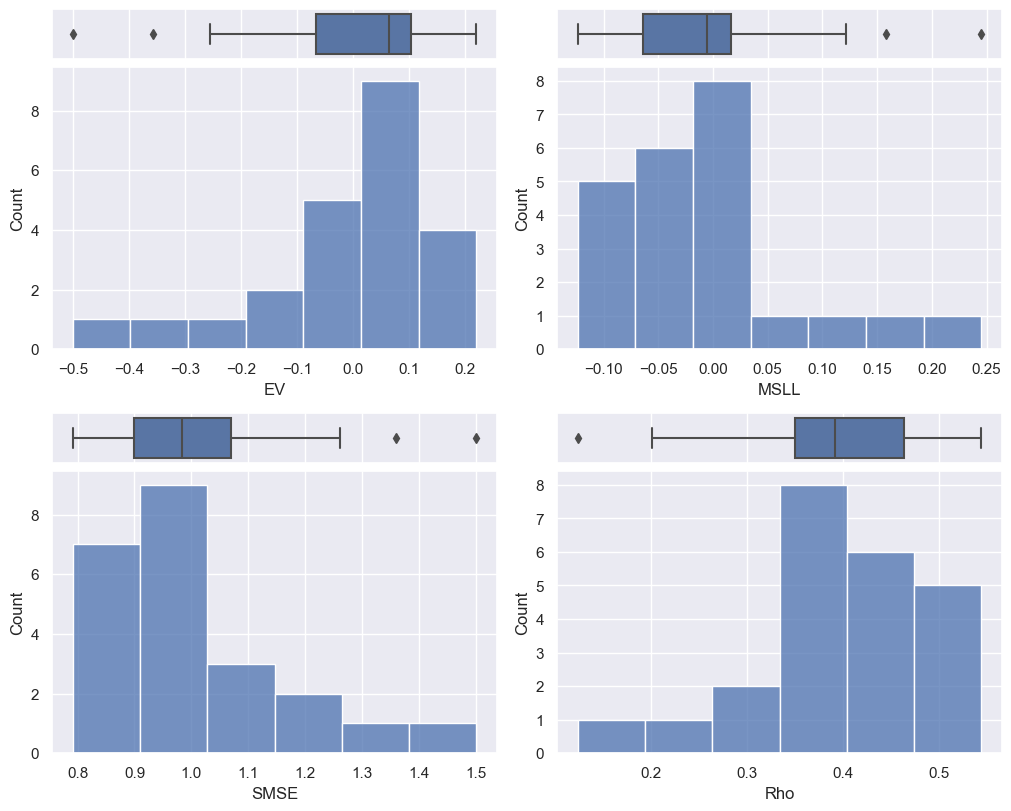

In [106]:
fig = plt.figure(constrained_layout=True,  figsize=(10,8))

subfigs = fig.subfigures(2, 2)
blr_metrics_TC = pd.read_csv(os.path.join(out_dir,'outputs', 'blr_metrics_TC.csv'))
metrics_TC = ['EV', 'MSLL', 'SMSE', 'Rho']

for outerind, subfig in enumerate(subfigs.flat):
    sns.set(style="darkgrid")
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    (ax_box, ax_hist) = subfig.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    # assigning a graph to each ax
    sns.boxplot(data=blr_metrics_TC, x =metrics_TC[outerind], ax=ax_box)
    sns.histplot(data=blr_metrics_TC, x=metrics_TC[outerind], ax=ax_hist)
    
    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')

plt.savefig(os.path.join(out_dir, 'outputs/metrics_TC.png'))
plt.show()

## 10. Save deviation scores
The deviation scores are output as a text file in separate folders. We want to summarize the deviation scores across all models estimates so we can organize them into a single file, and merge the deviation scores into the original data file.

In [107]:
#First for training set 
for idp_num, idp in enumerate(roi_ids): #Loop through ROIs
    
    #Set path to folder of ROI
    idp_dir = os.path.join(params['out_dir'],idp)
    os.chdir(idp_dir)
    
    #Extract and save the response variables for the test set
    y = df_brainfeatures_train[idp].to_numpy()
    
    #Save the variables
    resp_file = os.path.join(idp_dir, 'resp_' + 'tr' + '.txt')
    np.savetxt(resp_file,y)
    
    #configure and save the design matrix
    cov_file = os.path.join(idp_dir,'cov_bspline_' + 'tr' + '.txt')
    
    X = create_design_matrix(df_covariates_train[params['cols_cov']], 
                             site_ids = df_covariates_train['SITE_ID'],
                             all_sites = params['site_ids'],
                             basis = params['basis'], 
                             xmin = params['xmin'],
                             xmax = params['xmax'],
                             nknots = params['nknots'])
    
    np.savetxt(cov_file,X)

    #Make predictions
    predict(cov_file,
            alg=params['algo'], 
            respfile=resp_file, 
            model_path=os.path.join(idp_dir,'Models'),
            warp = params['warp'], warp_reparam=True,
            outputsuffix='_'+ 'tr')
 



    #Then for test set 
    
for idp_num, idp in enumerate(roi_ids): #Loop through ROIs
    
    #Set path to folder of ROI
    idp_dir = os.path.join(params['out_dir'],idp)
    os.chdir(idp_dir)
    
    #Extract and save the response variables for the test set
    y = df_brainfeatures_test[idp].to_numpy()
    
    #Save the variables
    resp_file = os.path.join(idp_dir, 'resp_' + 'te' + '.txt')
    np.savetxt(resp_file,y)
    
    #configure and save the design matrix
    cov_file = os.path.join(idp_dir,'cov_bspline_' + 'te' + '.txt')
    X = create_design_matrix(df_covariates_test[params['cols_cov']], 
                             site_ids = df_covariates_test['SITE_ID'],
                             all_sites = params['site_ids'],
                             basis = params['basis'], 
                             xmin = params['xmin'],
                             xmax = params['xmax'],
                             nknots = params['nknots'])
    
    np.savetxt(cov_file,X)
    
    #Make predictions
    predict(cov_file,
            alg=params['algo'], 
            respfile=resp_file, 
            model_path=os.path.join(idp_dir,'Models'),
            warp = params['warp'], warp_reparam=True,
            outputsuffix='_'+ 'te')

    
#Also for full dataframe so we can evaluate the Z scores for each participant
    
for idp_num, idp in enumerate(roi_ids): #Loop through ROIs
    
    #Set path to folder of ROI
    idp_dir = os.path.join(params['out_dir'],idp)
    os.chdir(idp_dir)
    
    #Extract and save the response variables for the test set
    y = df_brainfeatures[idp].to_numpy()
    
    #Save the variables
    resp_file = os.path.join(idp_dir, 'resp_' + 'all' + '.txt')
    np.savetxt(resp_file,y)
    
    #configure and save the design matrix
    cov_file = os.path.join(idp_dir,'cov_bspline_' + 'all' + '.txt')
    X = create_design_matrix(df_covariates[params['cols_cov']], 
                             site_ids = df_covariates['SITE_ID'],
                             all_sites = params['site_ids'],
                             basis = params['basis'], 
                             xmin = params['xmin'],
                             xmax = params['xmax'],
                             nknots = params['nknots'])
    
    np.savetxt(cov_file,X)
    
    #Make predictions
    predict(cov_file,
            alg=params['algo'], 
            respfile=resp_file, 
            model_path=os.path.join(idp_dir,'Models'),
            warp = params['warp'], warp_reparam=True,
            outputsuffix='_'+ 'all')

Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Predict

## 11. Write deviation scores to dataframe including sub ID

For the analysis we need to have the deviation scores for all ROIs in one file for all participants

In [108]:
#Define sub_ids and reset the index
sub_ids = all_data[["SUB_ID"]]
sub_ids = sub_ids.reset_index()


In [109]:
# Use a function to load the data since PCNtoolkit needs a specific format. Lets load this function
def load_2d(filename):
    """ this simple function loads a data type supported by PCNtoolkit and
        ensures that the output is a 2d numpy array
    """
    
    x = fileio.load(filename)
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    
    return x



# Make empty dataframe to store all evaluation variables
Deviation_scores = pd.DataFrame(columns=[roi_ids])


for idp_num, idp in enumerate(roi_ids): #Loop through all ROIs
    
    # Set path to folder of ROI
    idp_dir = os.path.join(out_dir, idp)
    
    #Load Z scores    
    Z = load_2d(os.path.join(idp_dir,'Z_all.txt'))
    
    
    Deviation_scores[idp] = Z[:,0]

    
Deviation_scores[['SUB_ID']] = sub_ids[['SUB_ID']]


        
#Save deviation scores
Deviation_scores.to_csv(os.path.join(out_dir,'outputs','Deviation_scores.csv'))



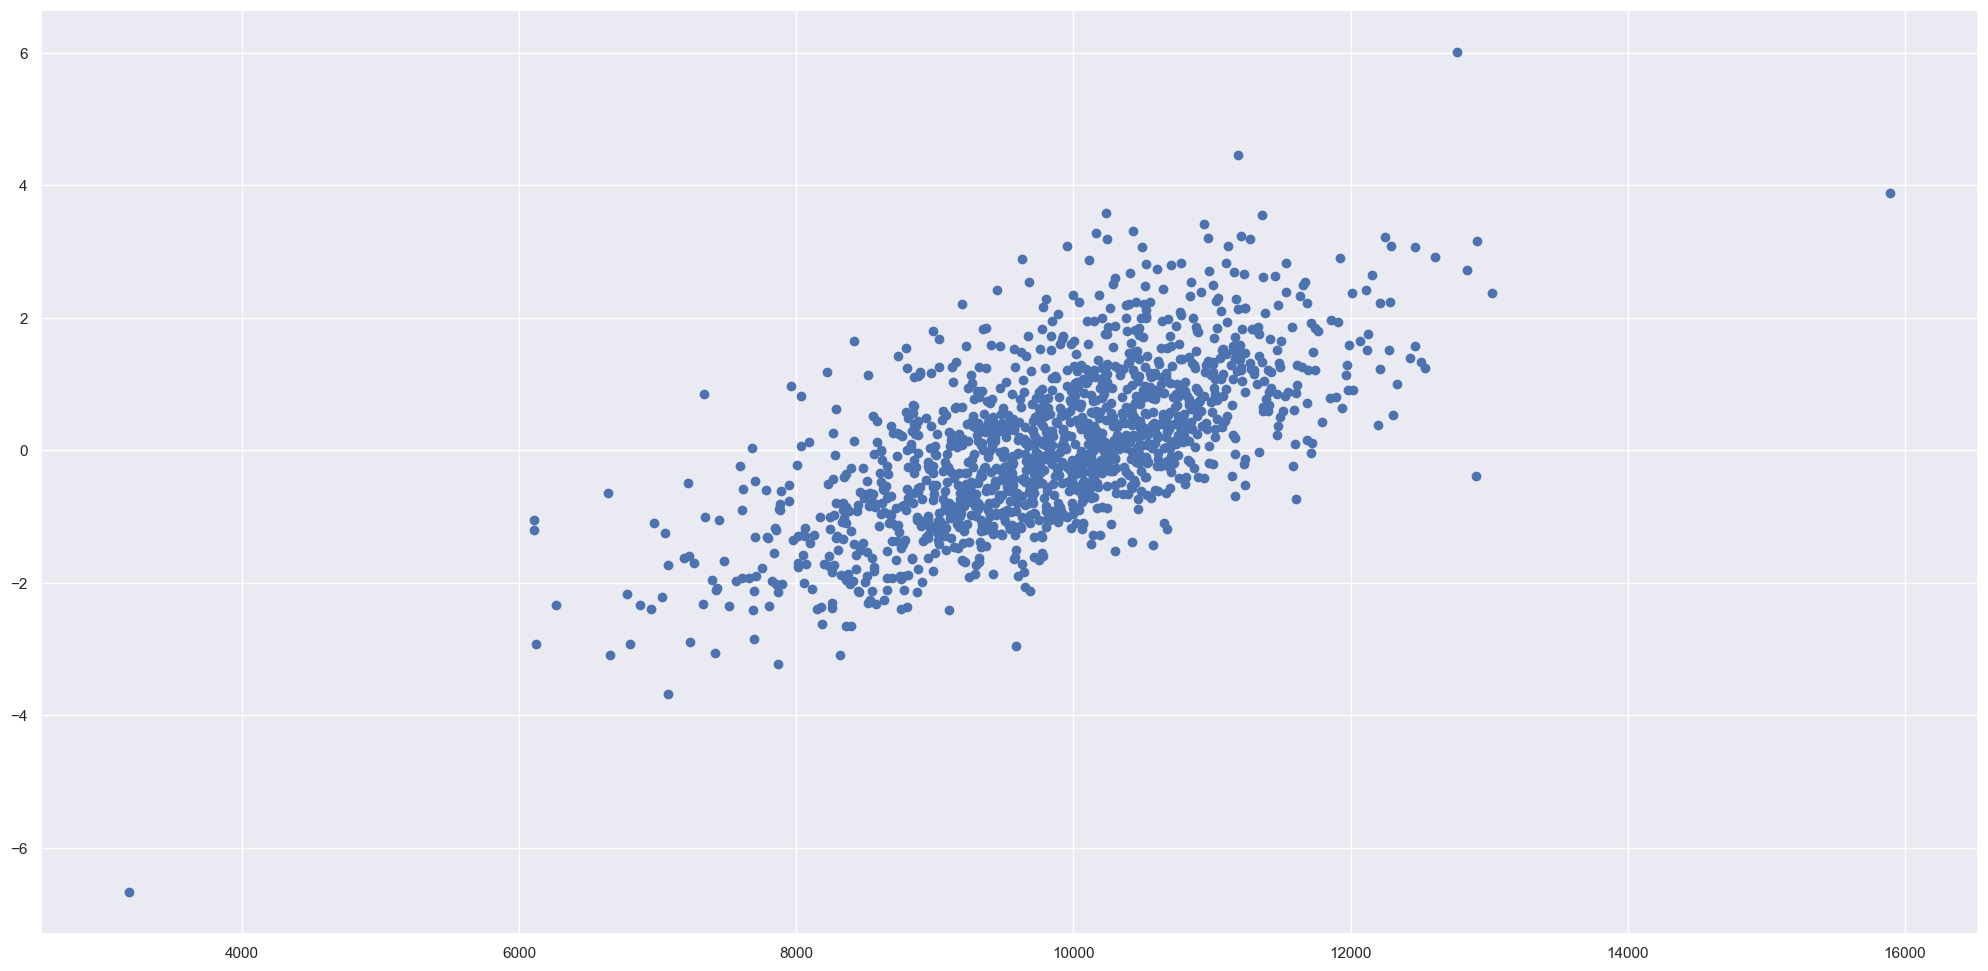

In [110]:
# Test to see if participants lined up with their own data. There should be a high correlation between original
# data and the deviation score. 

#for idp_num, idp in enumerate(roi_ids): #Loop through all ROIs
print(plt.scatter(all_data[[idp]], Deviation_scores[[idp]]))
plt.show()

# Plot

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([2958.95853948]), 'Rho': array([0.4245953]), 'pRho': array([4.21136305e-36]), 'SMSE': array([0.83543497]), 'EXPV': array([0.16460551])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([2936.93623222]), 'Rho': array([0.33828481]), 'pRho': array([9.47076997e-20]), 'SMSE': array([0.92099284]), 'EXPV': array([0.07942897])}


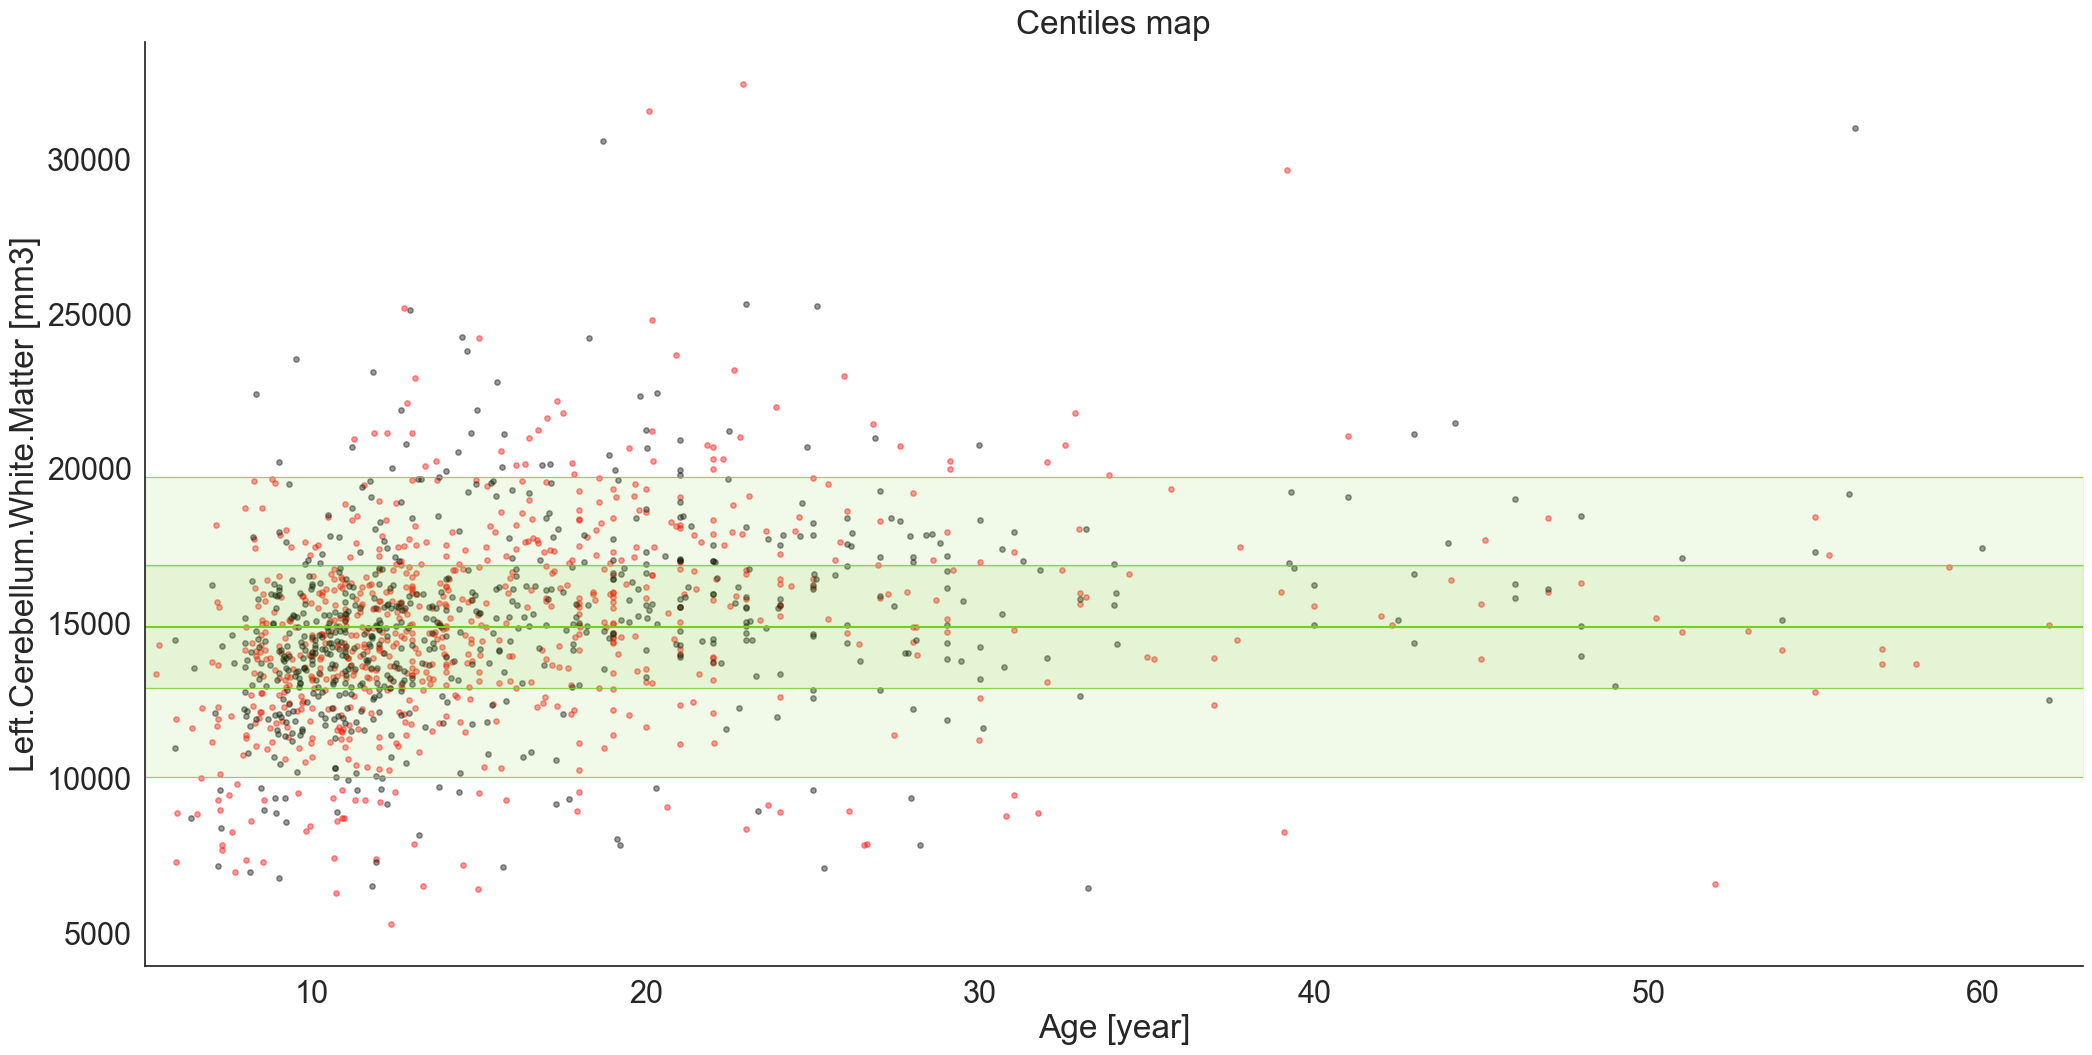

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([8807.33463665]), 'Rho': array([0.41810481]), 'pRho': array([6.4803623e-35]), 'SMSE': array([0.93674317]), 'EXPV': array([0.06945171])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([8261.01924164]), 'Rho': array([0.41867873]), 'pRho': array([1.03592117e-30]), 'SMSE': array([0.90700754]), 'EXPV': array([0.09395588])}


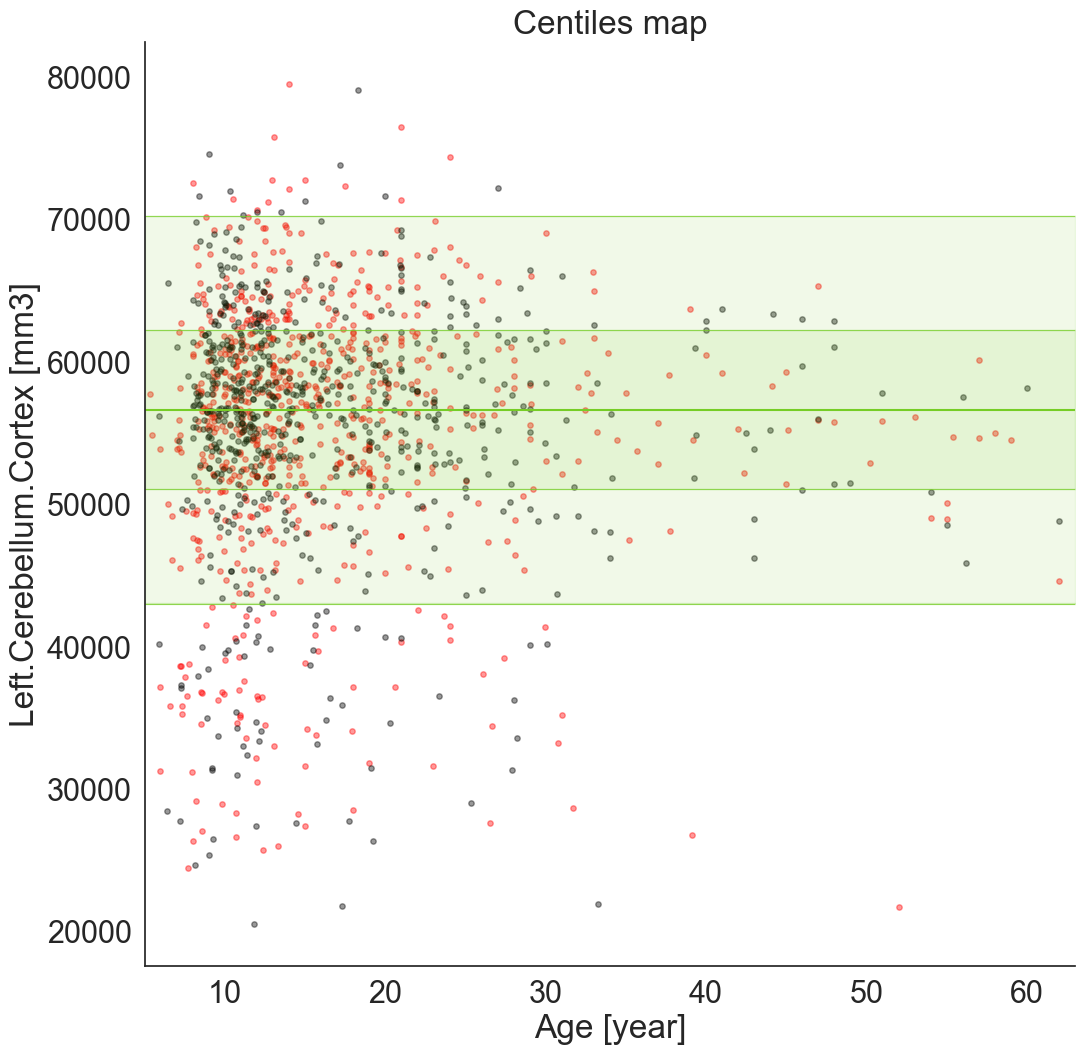

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([791.83977066]), 'Rho': array([0.61764989]), 'pRho': array([1.21873823e-88]), 'SMSE': array([0.67741304]), 'EXPV': array([0.33875801])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([776.59720569]), 'Rho': array([0.56372776]), 'pRho': array([4.74543909e-61]), 'SMSE': array([0.72988628]), 'EXPV': array([0.27045313])}


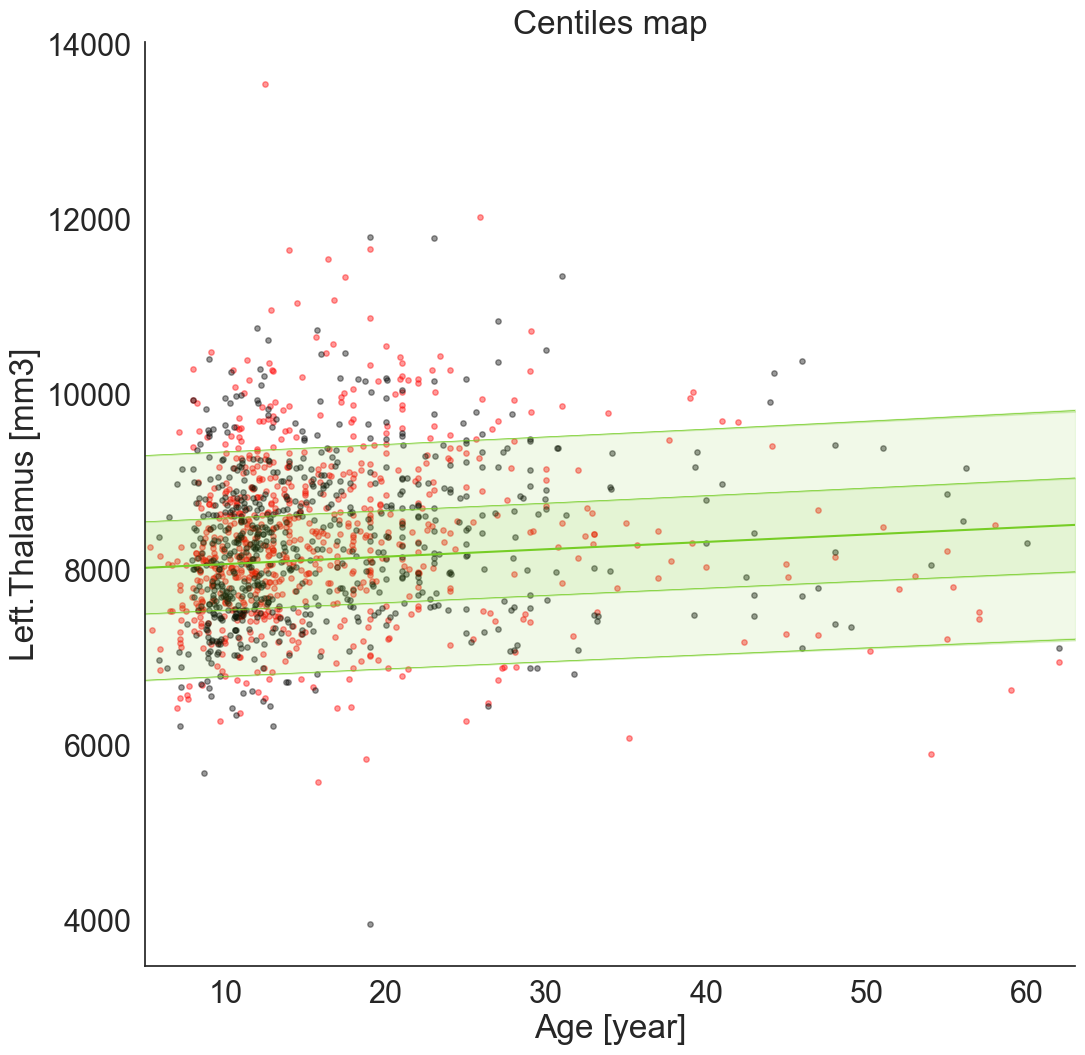

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([490.30839993]), 'Rho': array([0.47129404]), 'pRho': array([1.5506558e-45]), 'SMSE': array([0.81955127]), 'EXPV': array([0.20102531])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([483.24573939]), 'Rho': array([0.44067716]), 'pRho': array([2.50090087e-34]), 'SMSE': array([0.8367578]), 'EXPV': array([0.16330707])}


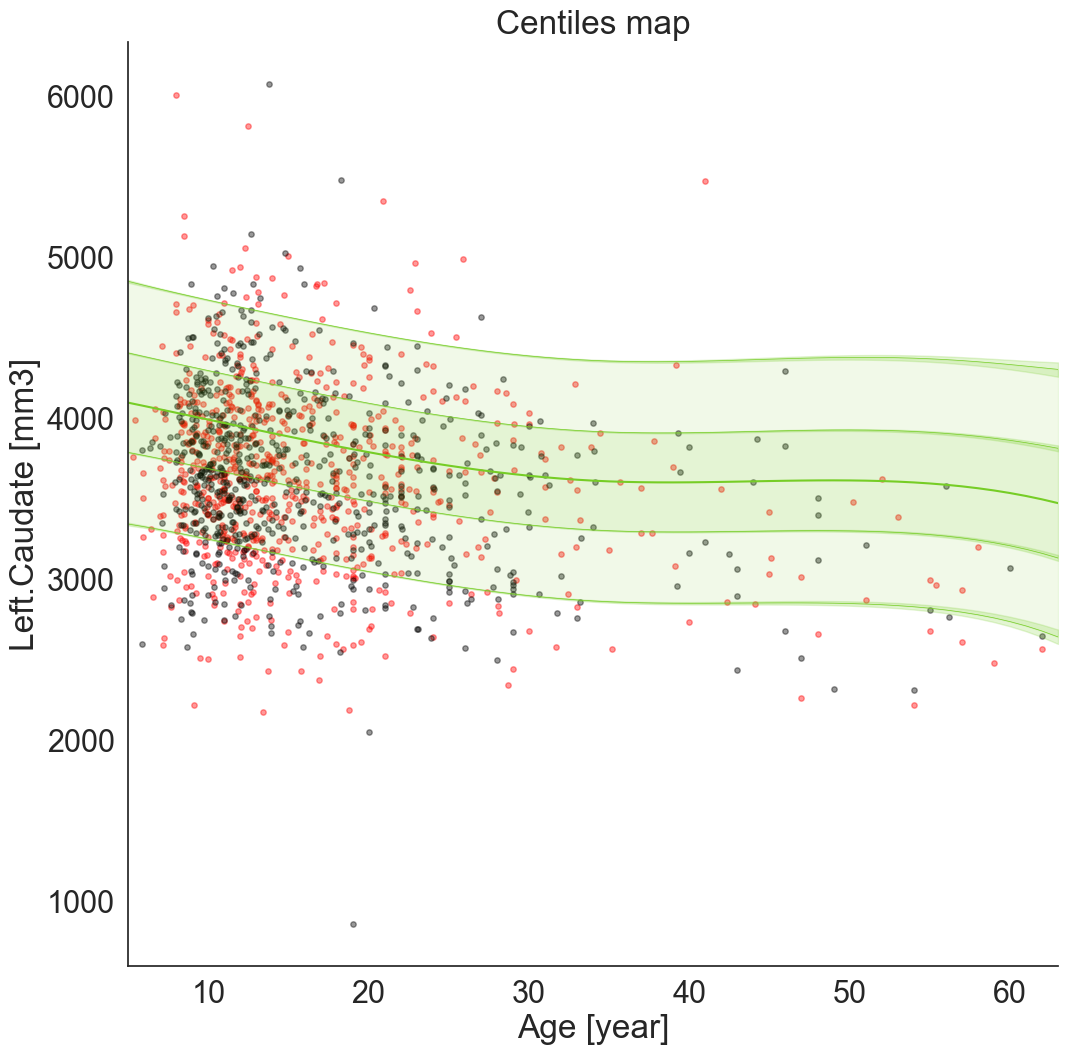

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([655.87871294]), 'Rho': array([0.41356098]), 'pRho': array([4.22582056e-34]), 'SMSE': array([0.93012127]), 'EXPV': array([0.07845185])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([616.82361809]), 'Rho': array([0.46261009]), 'pRho': array([3.07351399e-38]), 'SMSE': array([0.84862993]), 'EXPV': array([0.15252466])}


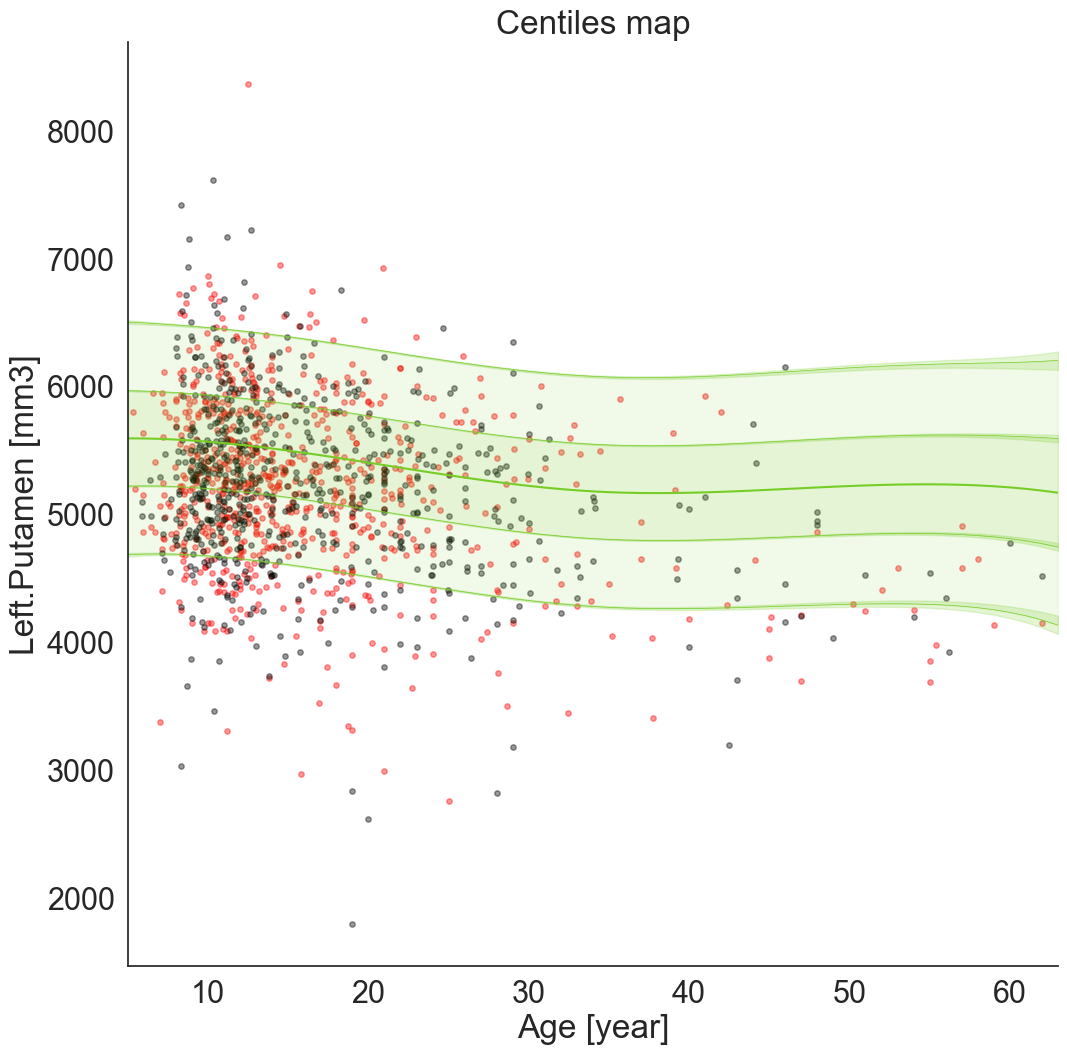

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([270.07864611]), 'Rho': array([0.49595984]), 'pRho': array([3.23544729e-51]), 'SMSE': array([0.84629774]), 'EXPV': array([0.2052937])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([252.56228976]), 'Rho': array([0.42622598]), 'pRho': array([6.41567727e-32]), 'SMSE': array([0.8899714]), 'EXPV': array([0.11059981])}


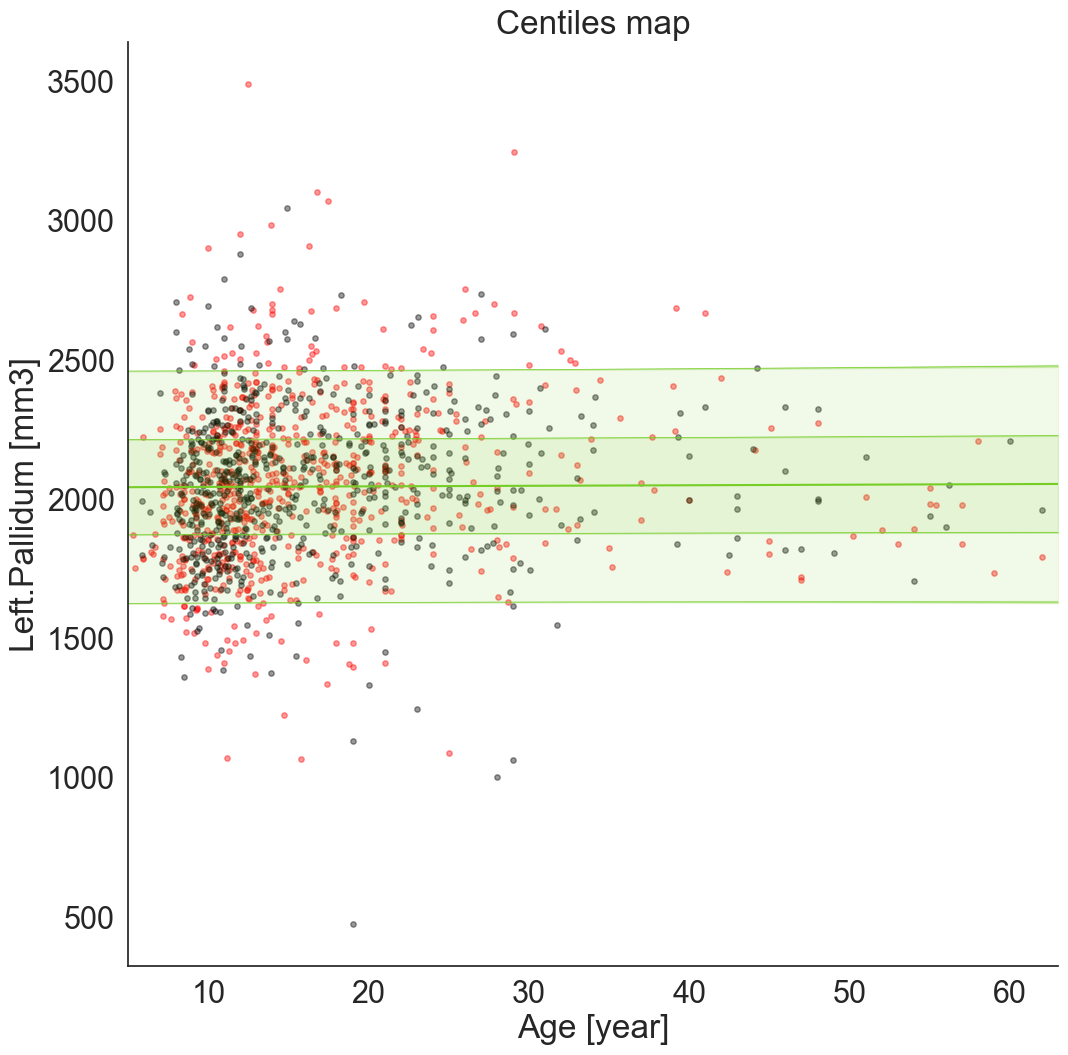

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([2564.32811647]), 'Rho': array([0.55432314]), 'pRho': array([5.90556792e-67]), 'SMSE': array([0.74365831]), 'EXPV': array([0.27210771])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([2534.20267502]), 'Rho': array([0.52458735]), 'pRho': array([3.57632385e-51]), 'SMSE': array([0.76403218]), 'EXPV': array([0.24892502])}


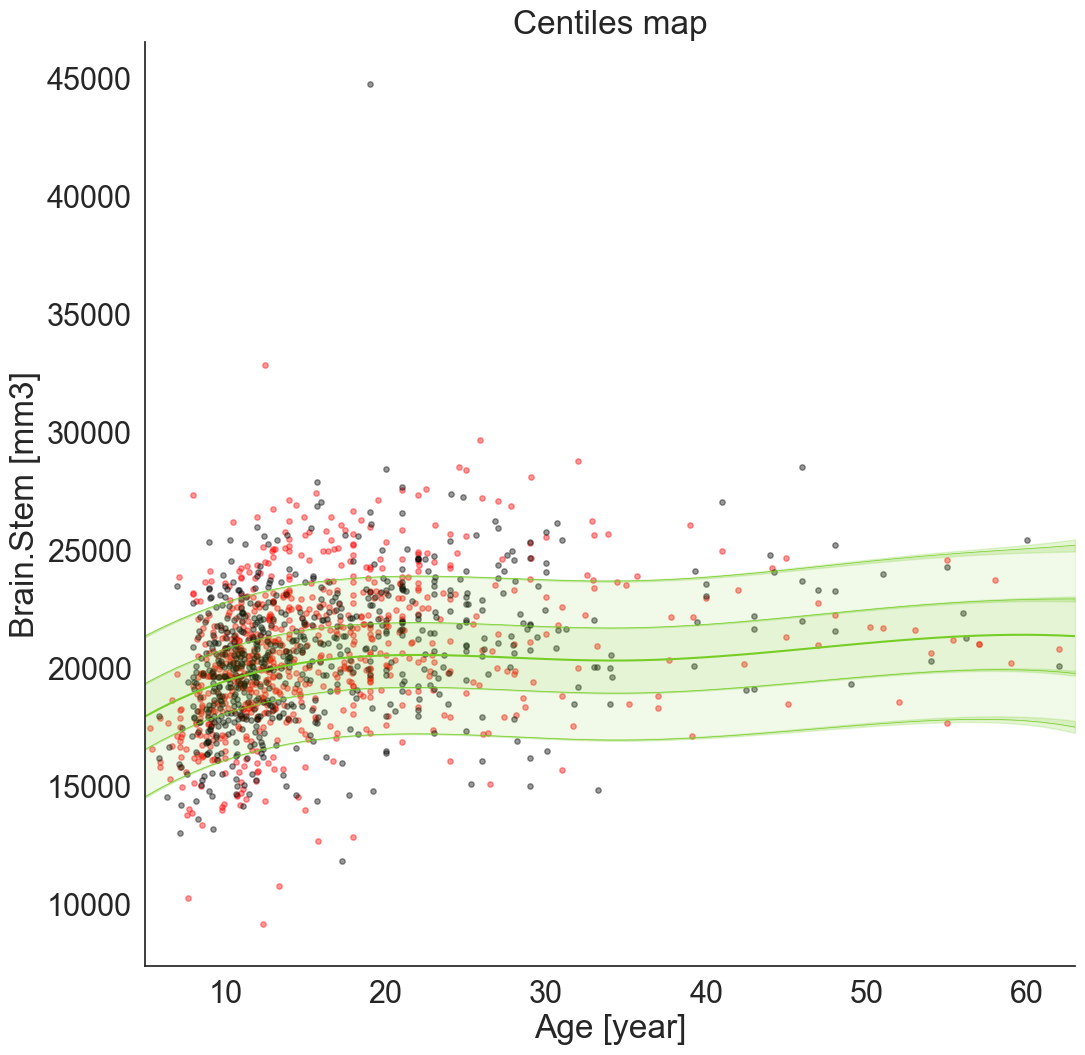

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([491.06815705]), 'Rho': array([0.47433329]), 'pRho': array([3.29856779e-46]), 'SMSE': array([0.87331745]), 'EXPV': array([0.13256603])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([522.71669004]), 'Rho': array([0.34290248]), 'pRho': array([2.71217346e-20]), 'SMSE': array([1.07875632]), 'EXPV': array([-0.05232915])}


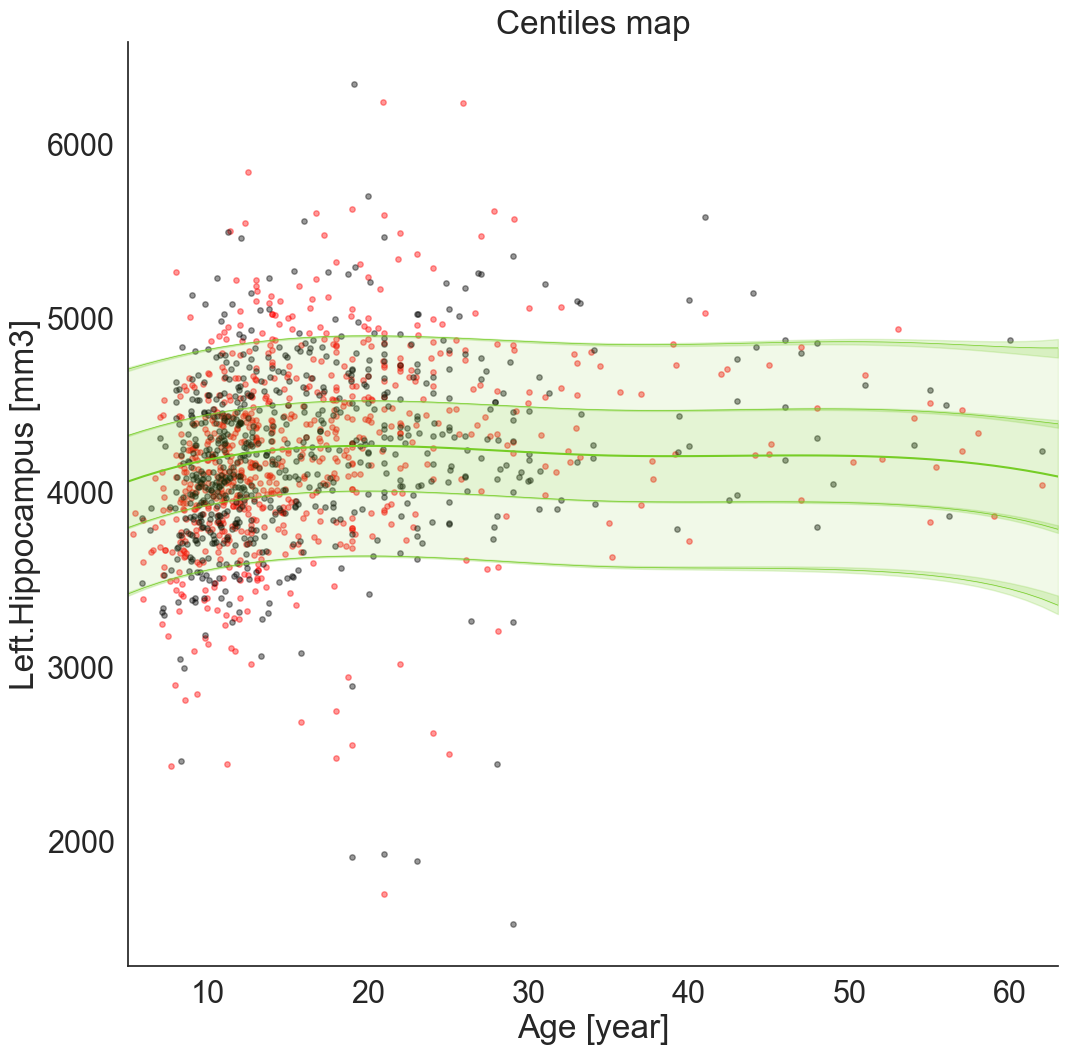

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([249.05641686]), 'Rho': array([0.55005339]), 'pRho': array([1.11079141e-65]), 'SMSE': array([0.72616821]), 'EXPV': array([0.28558641])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([237.8333345]), 'Rho': array([0.4992862]), 'pRho': array([1.57446376e-45]), 'SMSE': array([0.7786816]), 'EXPV': array([0.22162622])}


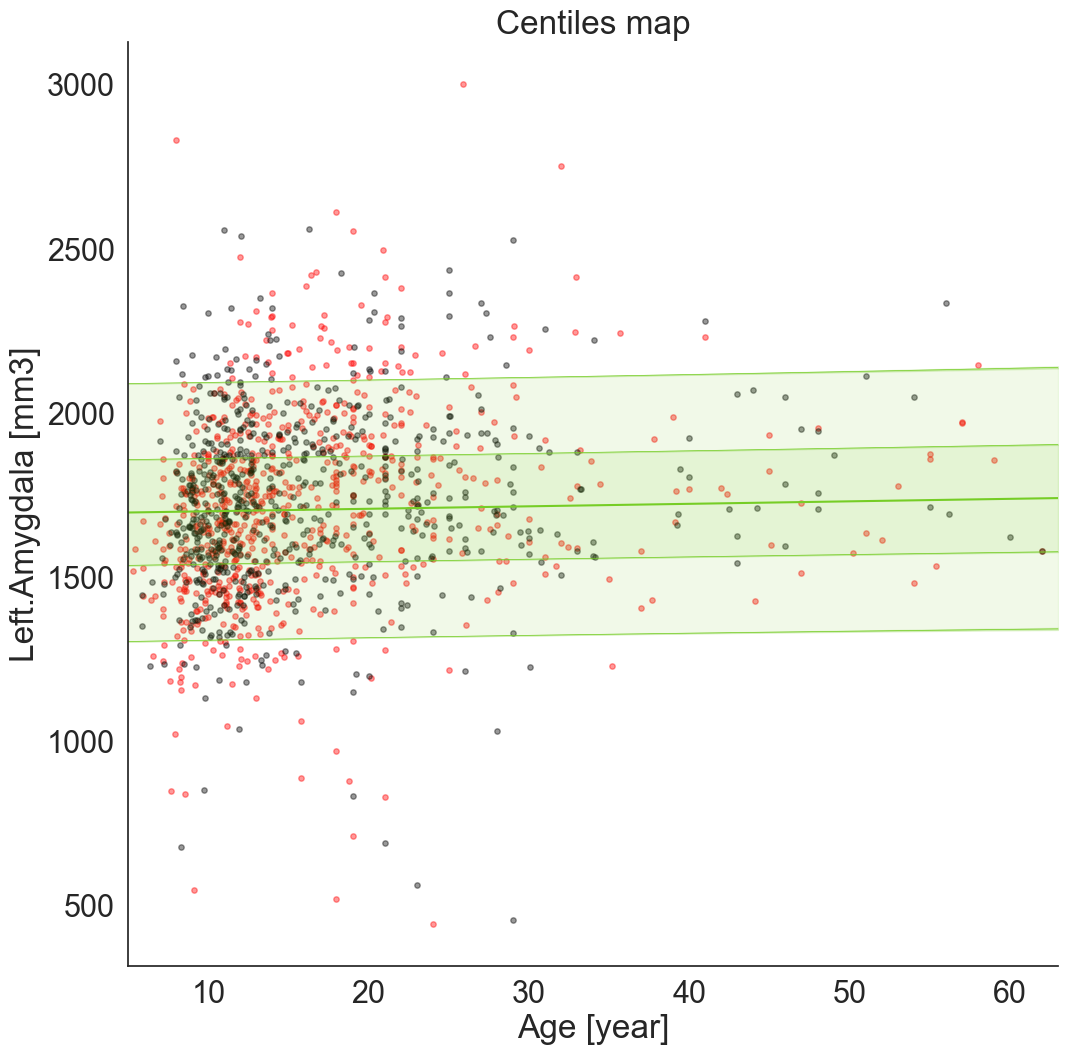

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([157.01022914]), 'Rho': array([0.26734773]), 'pRho': array([3.36197458e-14]), 'SMSE': array([1.18010782]), 'EXPV': array([-0.17289245])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([141.63798014]), 'Rho': array([0.35827835]), 'pRho': array([3.57728901e-22]), 'SMSE': array([1.03925732]), 'EXPV': array([-0.03916095])}


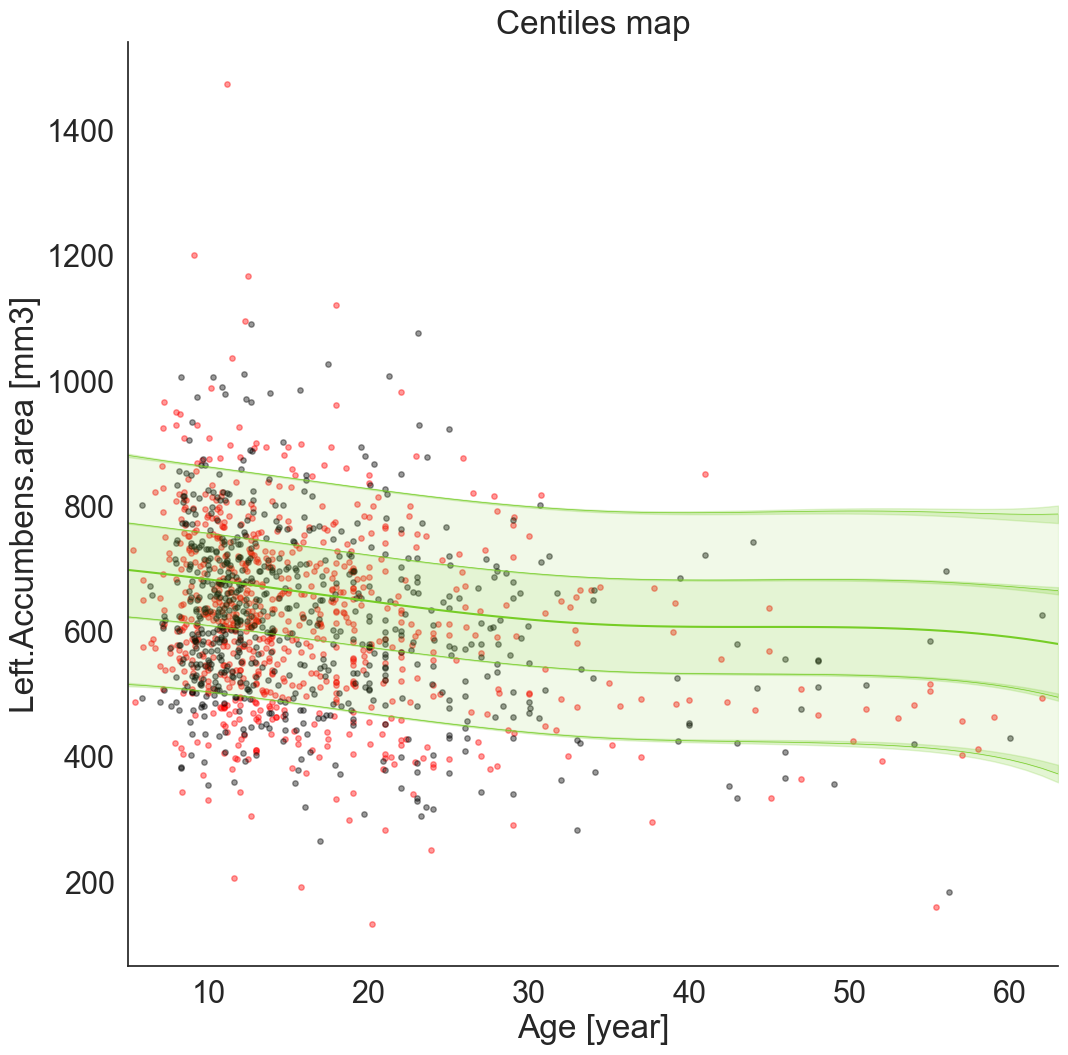

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([453.70171494]), 'Rho': array([0.51539685]), 'pRho': array([4.4700359e-56]), 'SMSE': array([0.80716211]), 'EXPV': array([0.19416328])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([451.11094508]), 'Rho': array([0.47957112]), 'pRho': array([1.7340427e-41]), 'SMSE': array([0.86296587]), 'EXPV': array([0.14638558])}


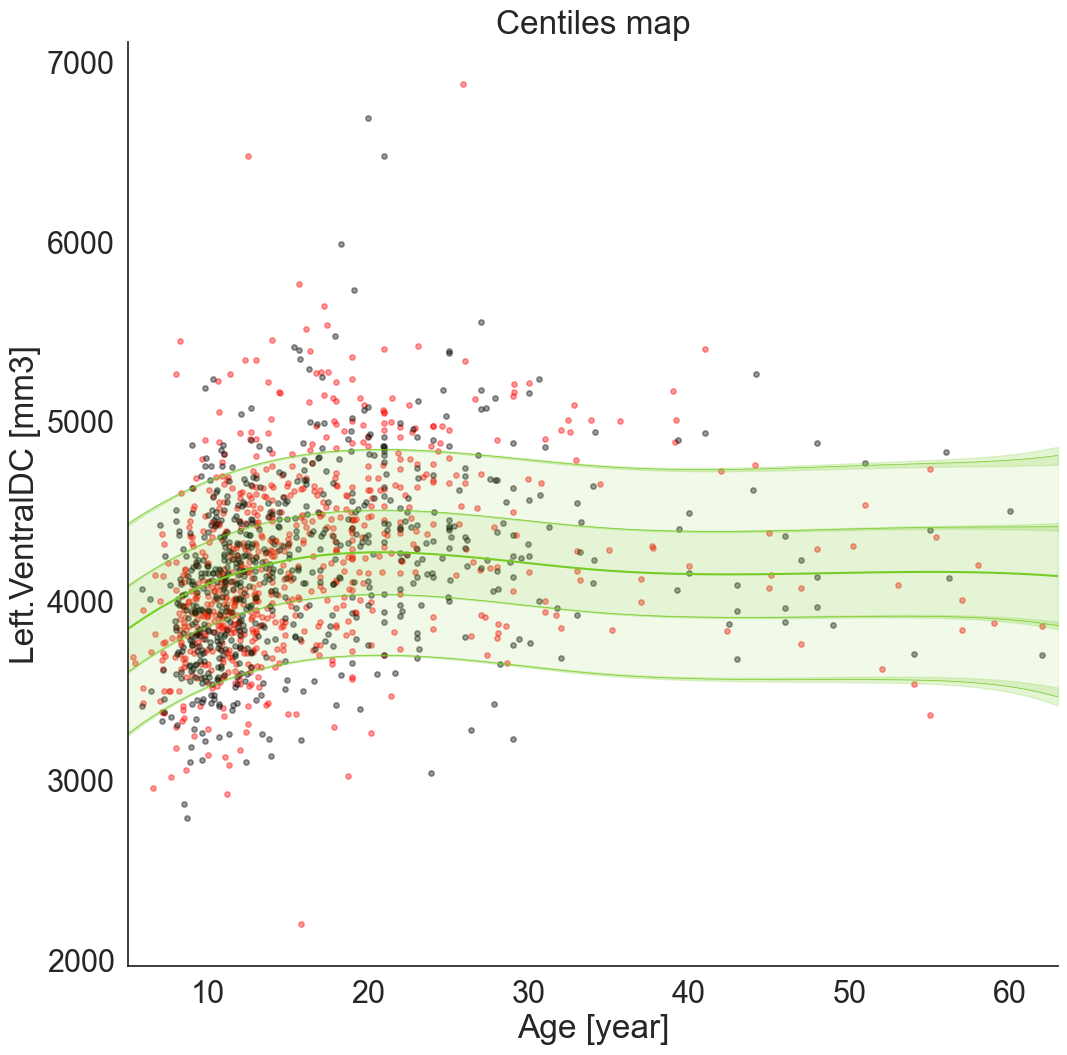

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([2809.91417545]), 'Rho': array([0.42026495]), 'pRho': array([2.62812257e-35]), 'SMSE': array([0.84304054]), 'EXPV': array([0.15992227])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([2833.36993704]), 'Rho': array([0.31727474]), 'pRho': array([2.12231711e-17]), 'SMSE': array([0.9409657]), 'EXPV': array([0.0595275])}


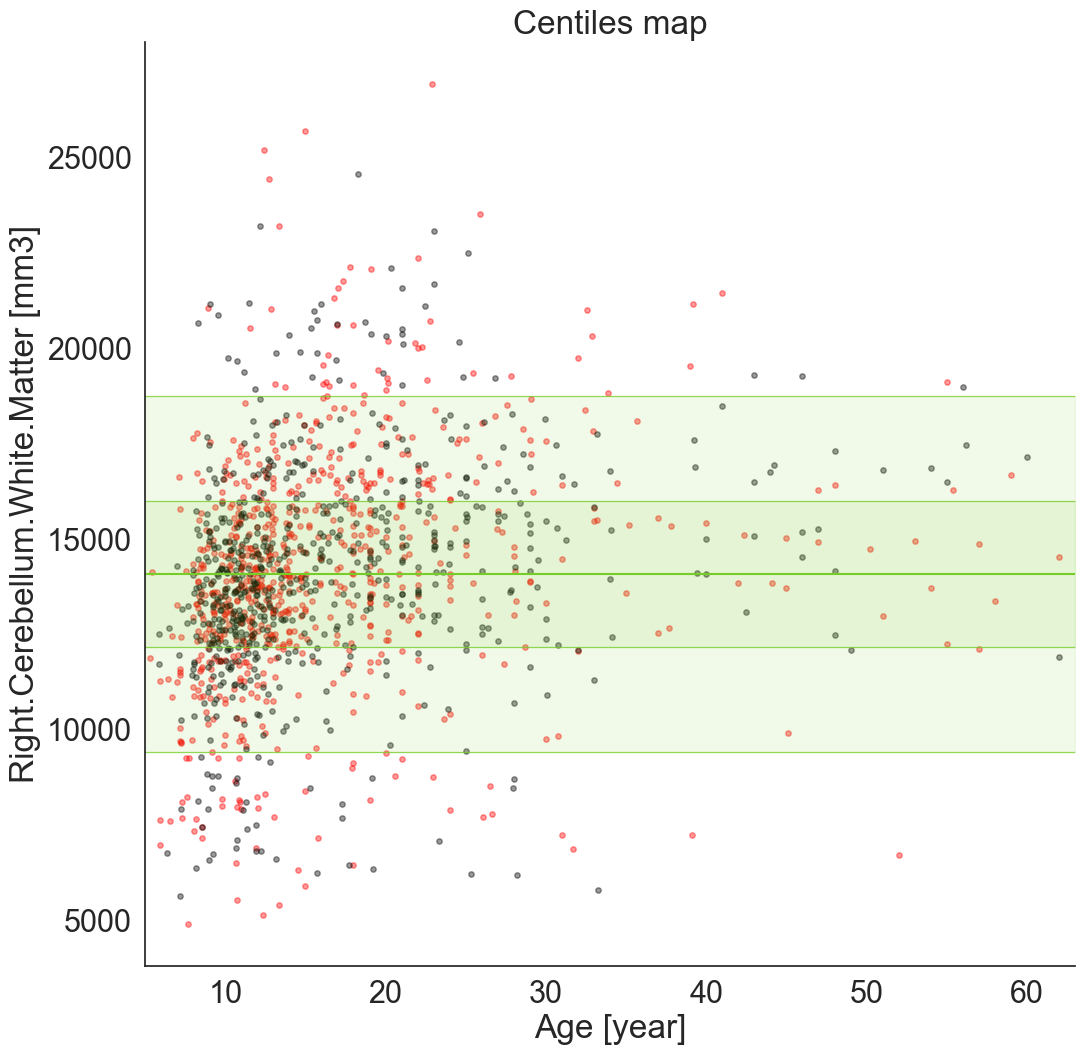

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([8806.90656629]), 'Rho': array([0.44015147]), 'pRho': array([4.57613046e-39]), 'SMSE': array([0.89004945]), 'EXPV': array([0.1116442])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([8260.69724312]), 'Rho': array([0.42267085]), 'pRho': array([2.40161292e-31]), 'SMSE': array([0.90167521]), 'EXPV': array([0.09926493])}


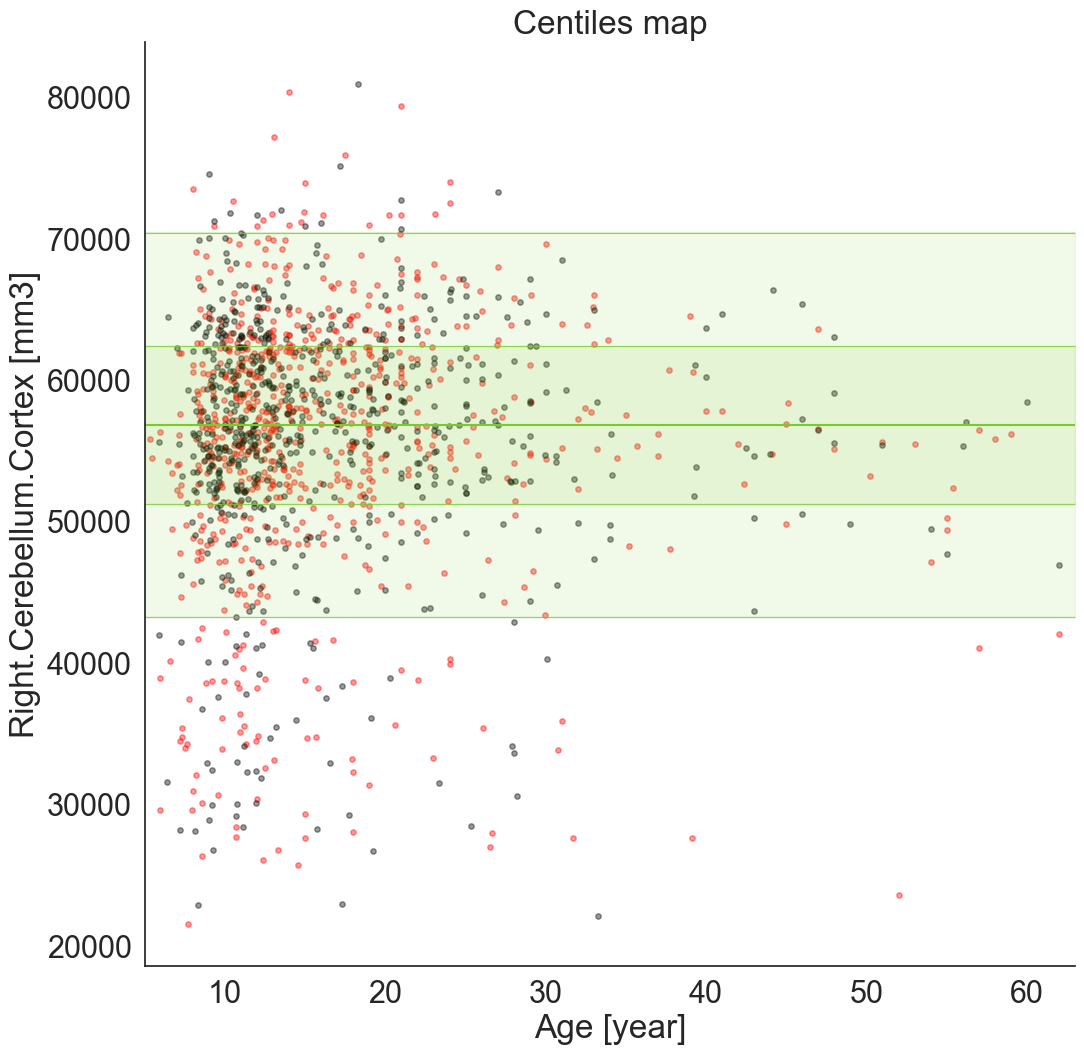

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([755.50538355]), 'Rho': array([0.61433936]), 'pRho': array([2.31380135e-87]), 'SMSE': array([0.70405369]), 'EXPV': array([0.31772706])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([750.37251707]), 'Rho': array([0.54353717]), 'pRho': array([9.0655958e-56]), 'SMSE': array([0.77910997]), 'EXPV': array([0.22143783])}


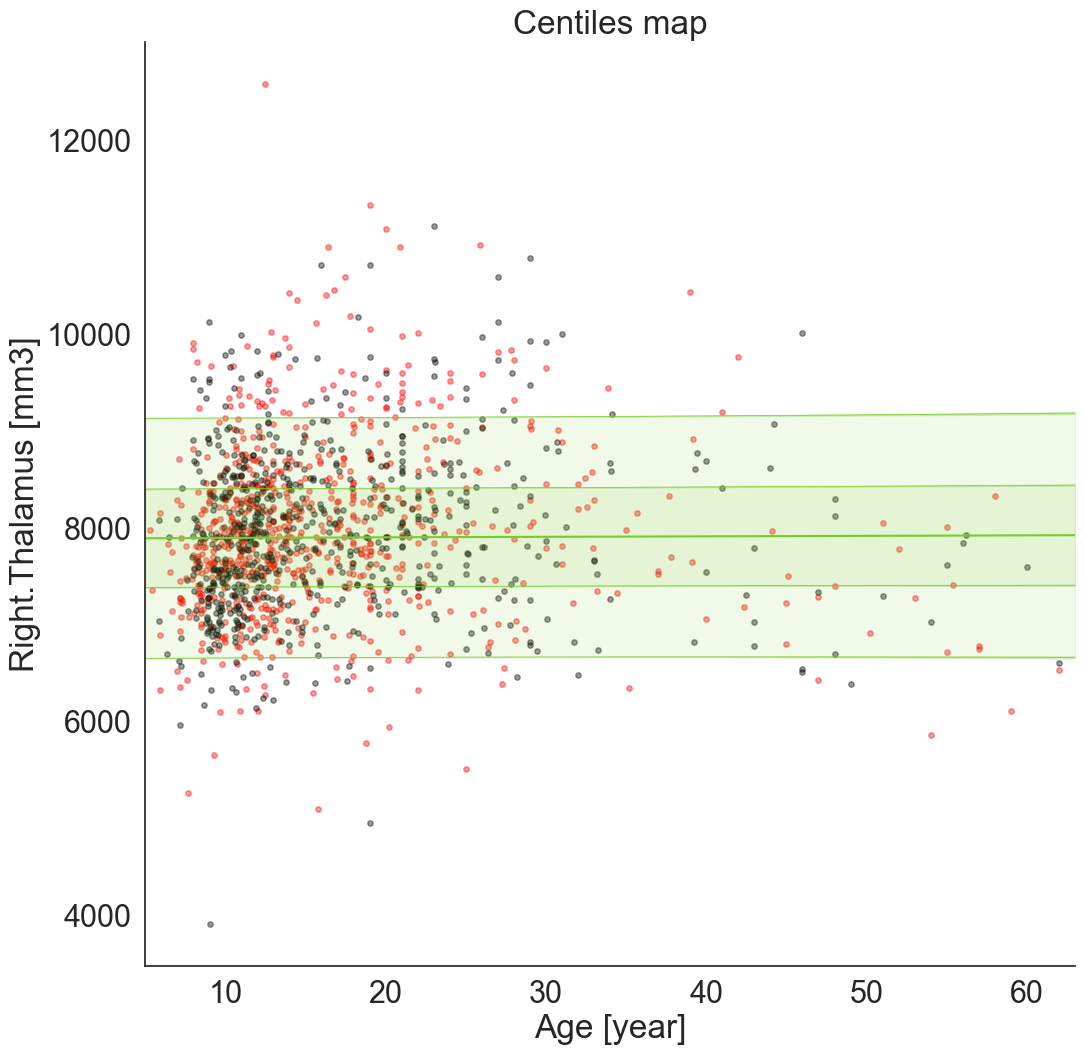

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([505.37776578]), 'Rho': array([0.47450038]), 'pRho': array([3.02796148e-46]), 'SMSE': array([0.8259582]), 'EXPV': array([0.1904483])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([506.35291272]), 'Rho': array([0.43383375]), 'pRho': array([3.58883507e-33]), 'SMSE': array([0.86280729]), 'EXPV': array([0.13727268])}


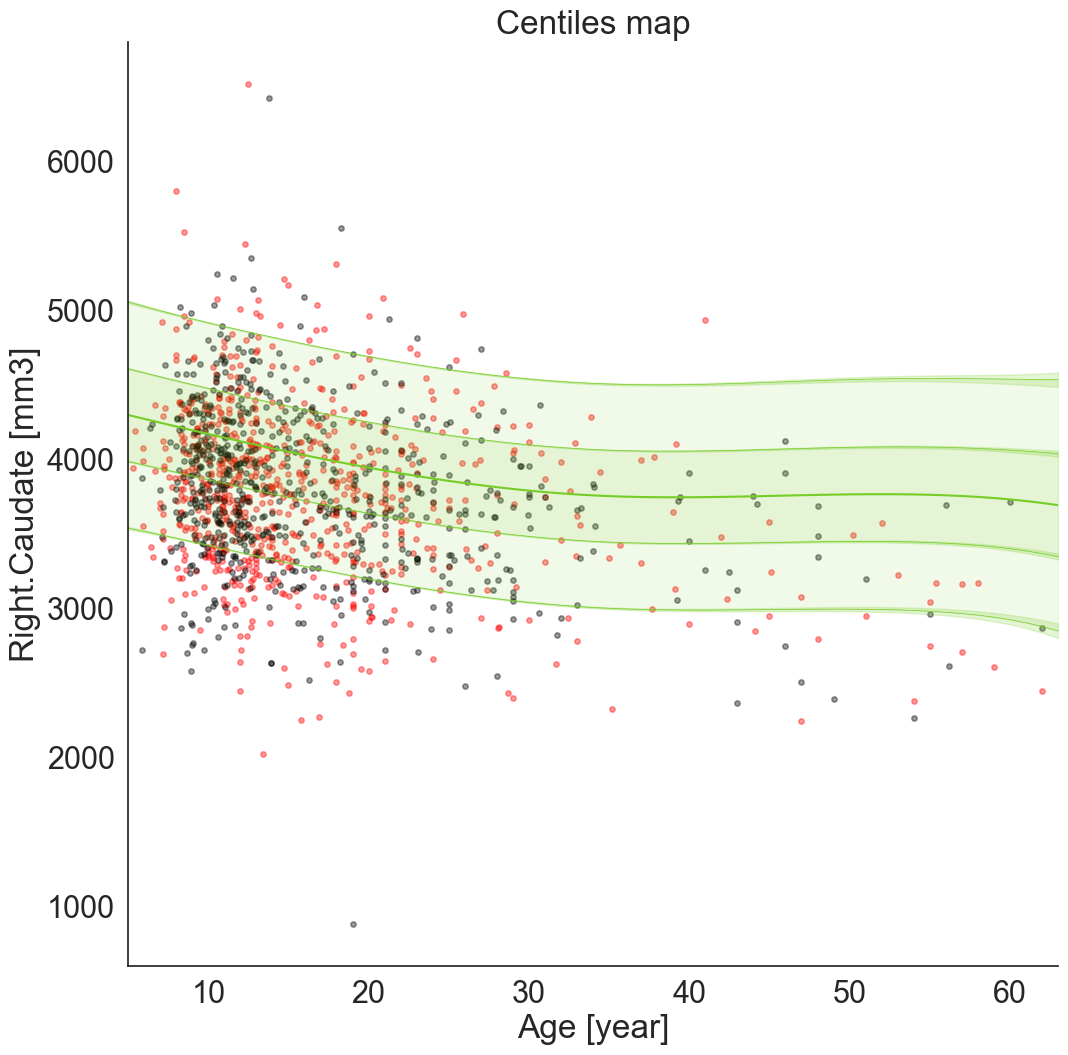

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([636.29168273]), 'Rho': array([0.43892536]), 'pRho': array([7.9494051e-39]), 'SMSE': array([0.90828227]), 'EXPV': array([0.10147457])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([603.67395733]), 'Rho': array([0.45962856]), 'pRho': array([1.09134478e-37]), 'SMSE': array([0.86515768]), 'EXPV': array([0.13517933])}


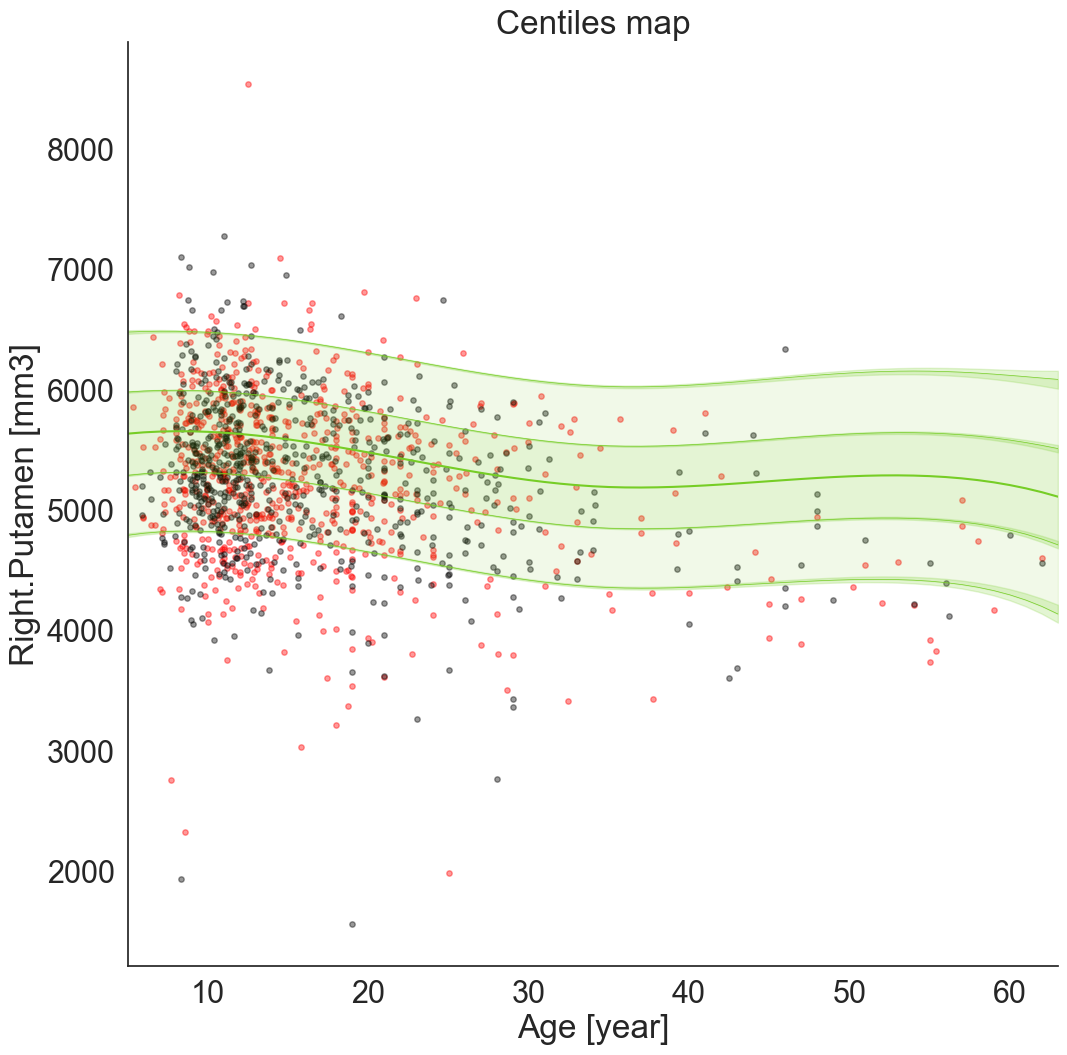

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([256.87335327]), 'Rho': array([0.51104535]), 'pRho': array([5.8788603e-55]), 'SMSE': array([0.80654539]), 'EXPV': array([0.22834201])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([244.22135471]), 'Rho': array([0.47334274]), 'pRho': array([2.85575207e-40]), 'SMSE': array([0.81310106]), 'EXPV': array([0.18720068])}


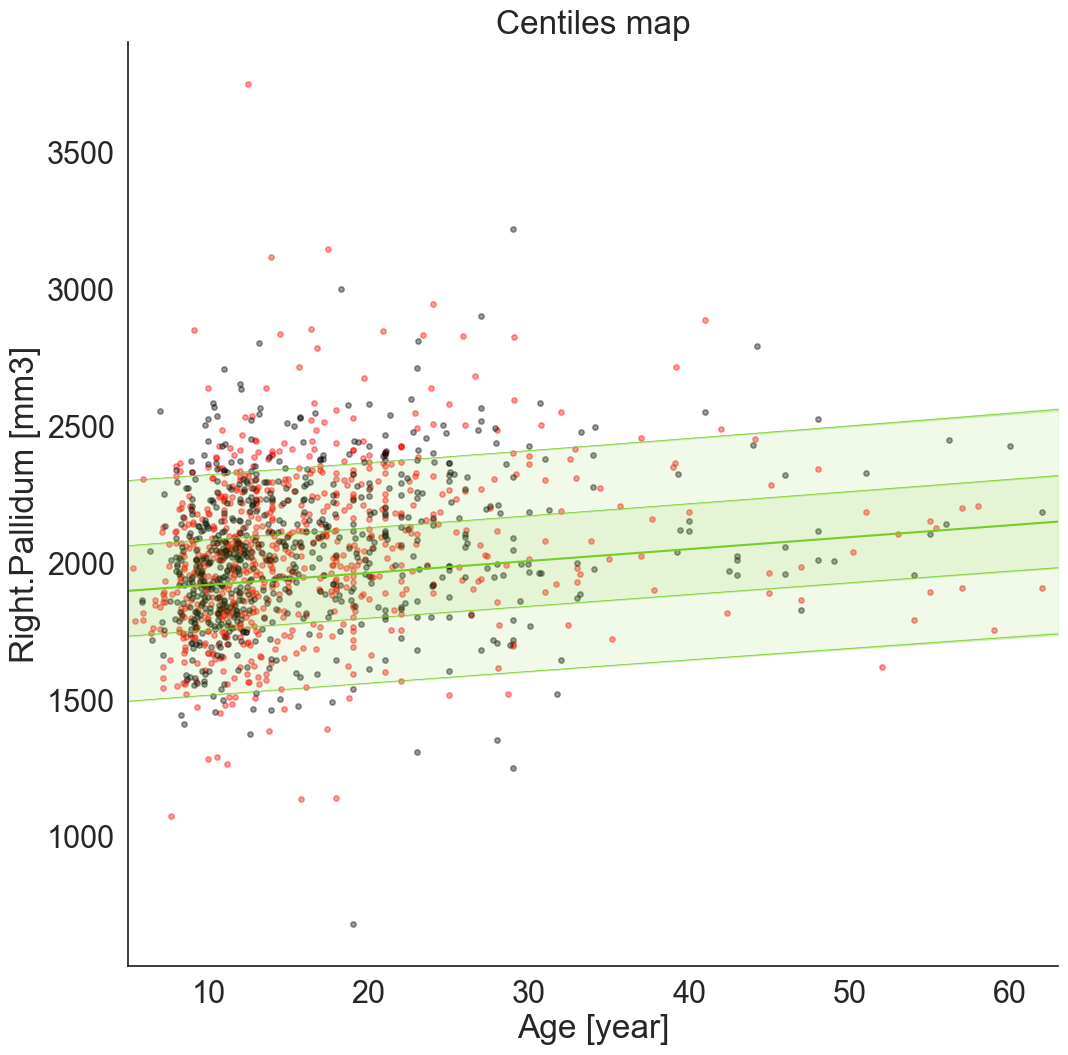

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([495.96410634]), 'Rho': array([0.47921677]), 'pRho': array([2.64409132e-47]), 'SMSE': array([0.85929379]), 'EXPV': array([0.14605364])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([535.86449455]), 'Rho': array([0.33156338]), 'pRho': array([5.61811877e-19]), 'SMSE': array([1.09499188]), 'EXPV': array([-0.06148078])}


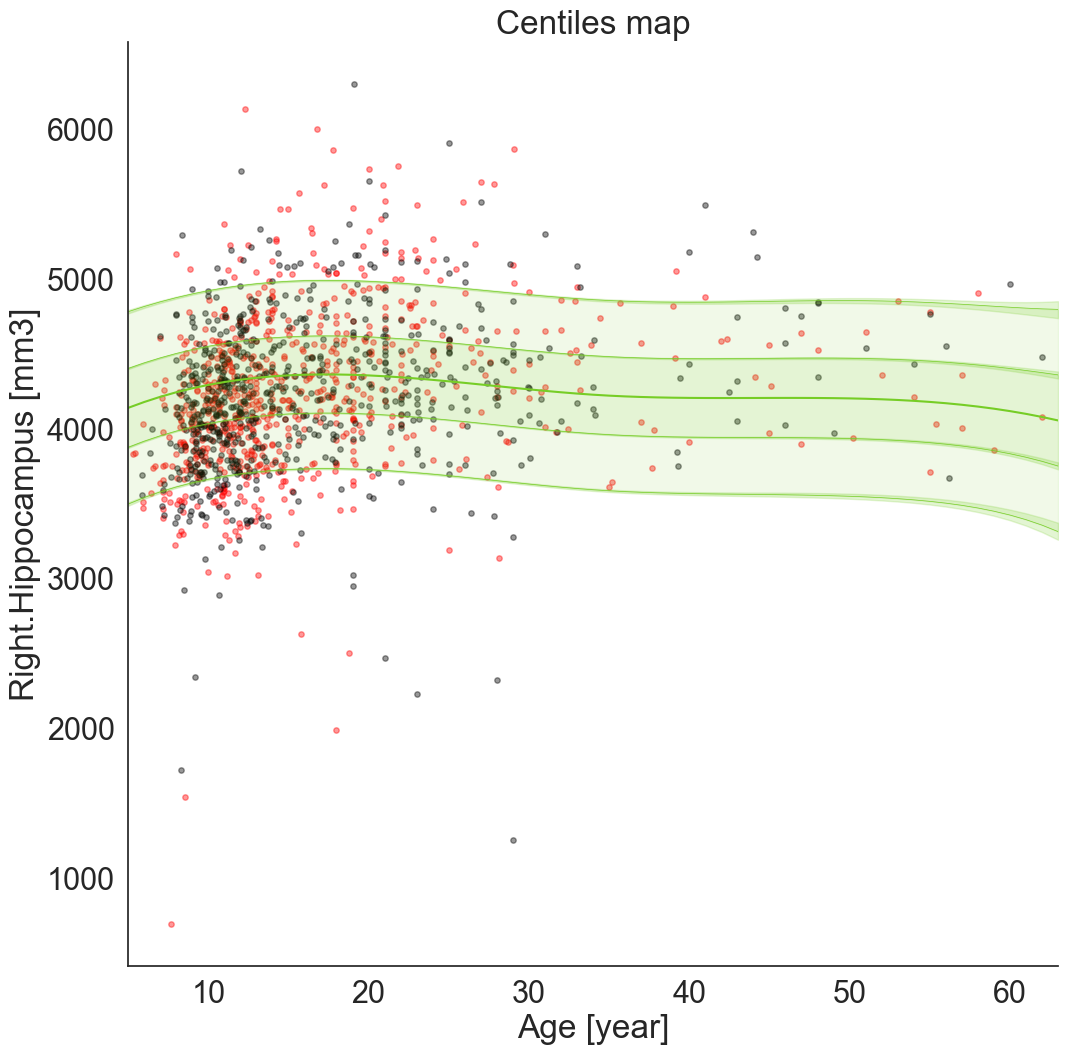

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([243.82893239]), 'Rho': array([0.56462335]), 'pRho': array([4.05635428e-70]), 'SMSE': array([0.71441566]), 'EXPV': array([0.29614426])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([242.9524608]), 'Rho': array([0.50686451]), 'pRho': array([3.65302976e-47]), 'SMSE': array([0.77194444]), 'EXPV': array([0.2283595])}


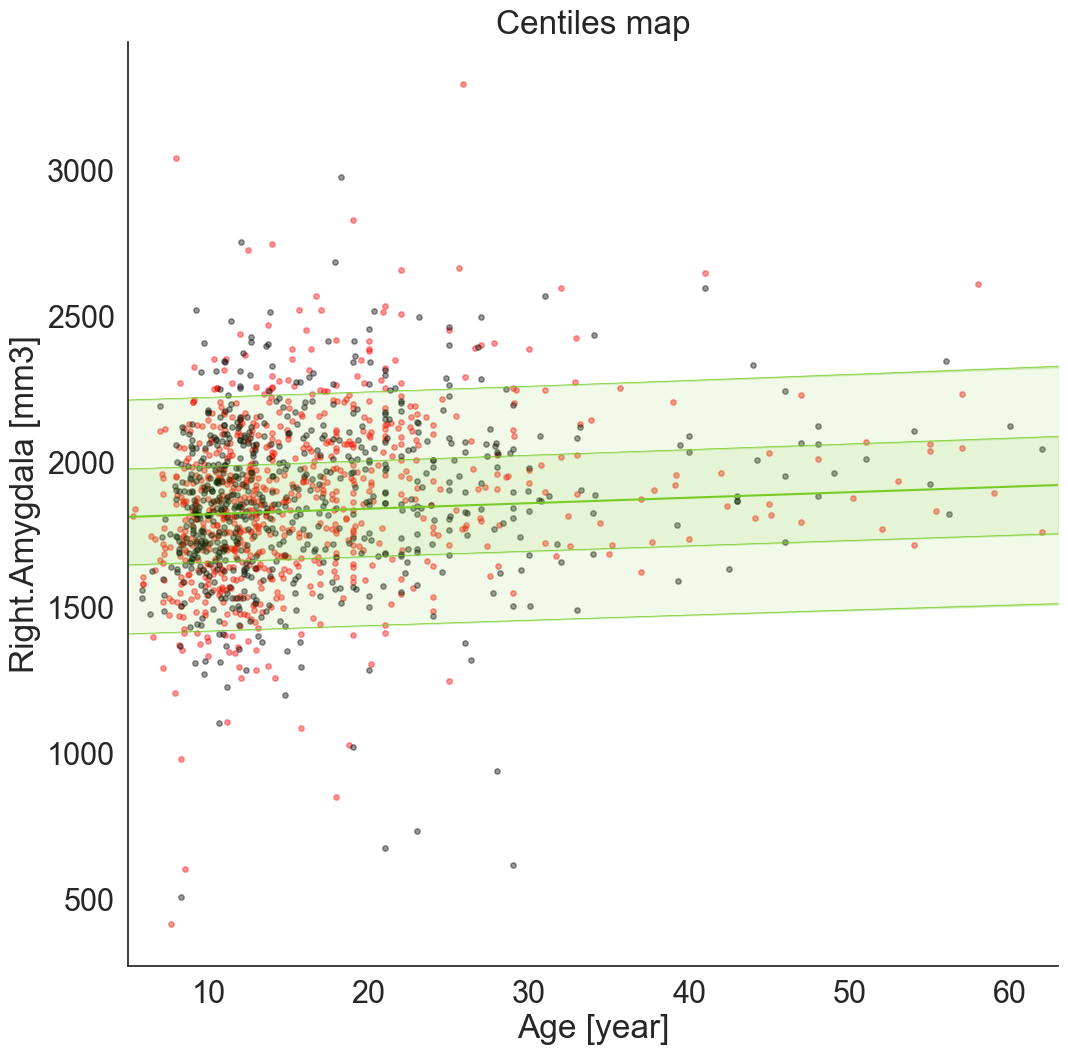

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([137.71045959]), 'Rho': array([0.27270202]), 'pRho': array([9.67887219e-15]), 'SMSE': array([1.17740054]), 'EXPV': array([-0.17739104])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([135.73995595]), 'Rho': array([0.294966]), 'pRho': array([4.12315618e-15]), 'SMSE': array([1.10154577]), 'EXPV': array([-0.09621527])}


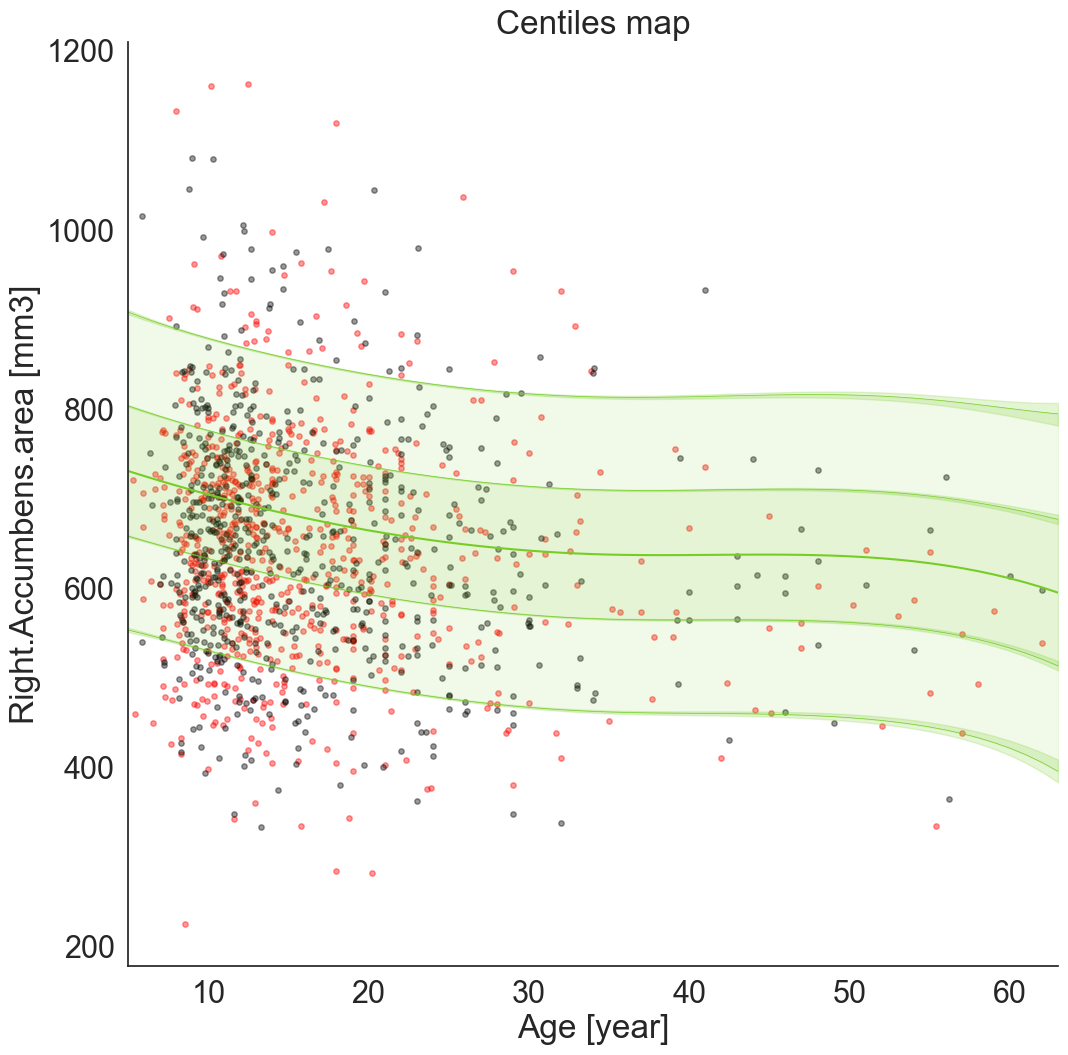

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([463.19159868]), 'Rho': array([0.49319975]), 'pRho': array([1.48519009e-50]), 'SMSE': array([0.86460903]), 'EXPV': array([0.13655059])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([471.28642017]), 'Rho': array([0.44165098]), 'pRho': array([1.70252006e-34]), 'SMSE': array([0.93212397]), 'EXPV': array([0.07594656])}


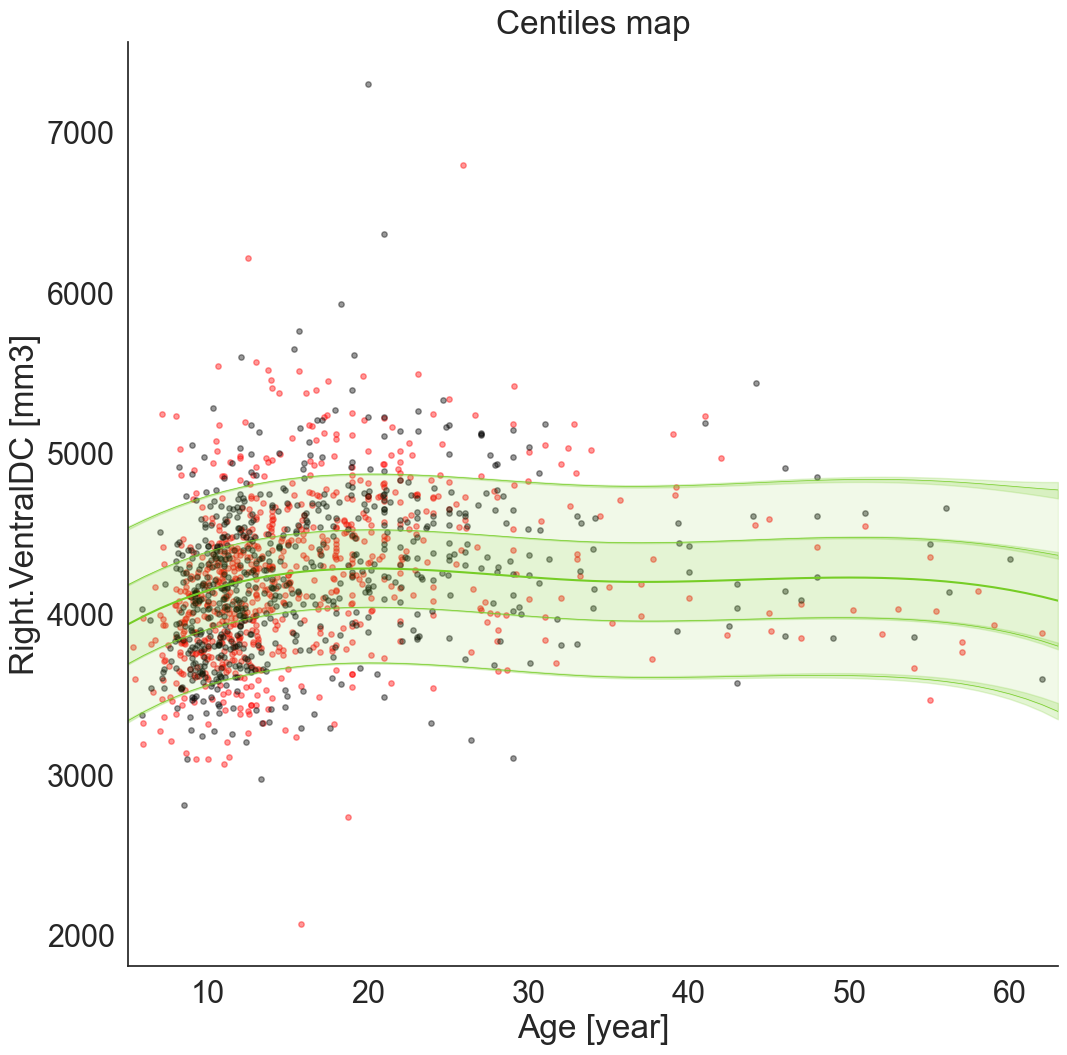

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([966.26462603]), 'Rho': array([0.50024551]), 'pRho': array([2.942044e-52]), 'SMSE': array([0.82616802]), 'EXPV': array([0.18742186])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([926.75398198]), 'Rho': array([0.51916744]), 'pRho': array([6.42844137e-50]), 'SMSE': array([0.78291946]), 'EXPV': array([0.21823886])}


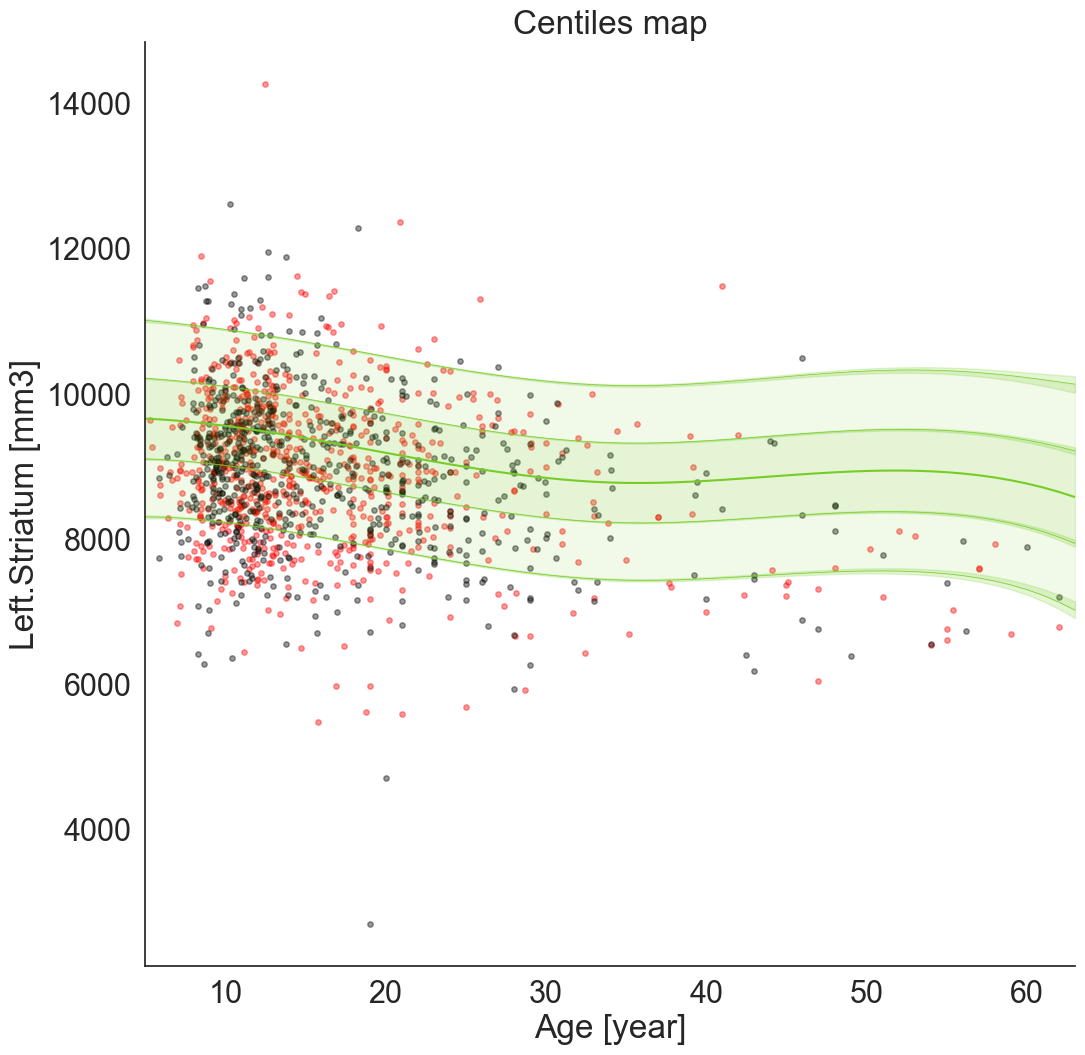

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([970.01191421]), 'Rho': array([0.522947]), 'pRho': array([4.6198807e-58]), 'SMSE': array([0.80233293]), 'EXPV': array([0.2104854])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([936.69157217]), 'Rho': array([0.51980052]), 'pRho': array([4.60127267e-50]), 'SMSE': array([0.796907]), 'EXPV': array([0.2036547])}


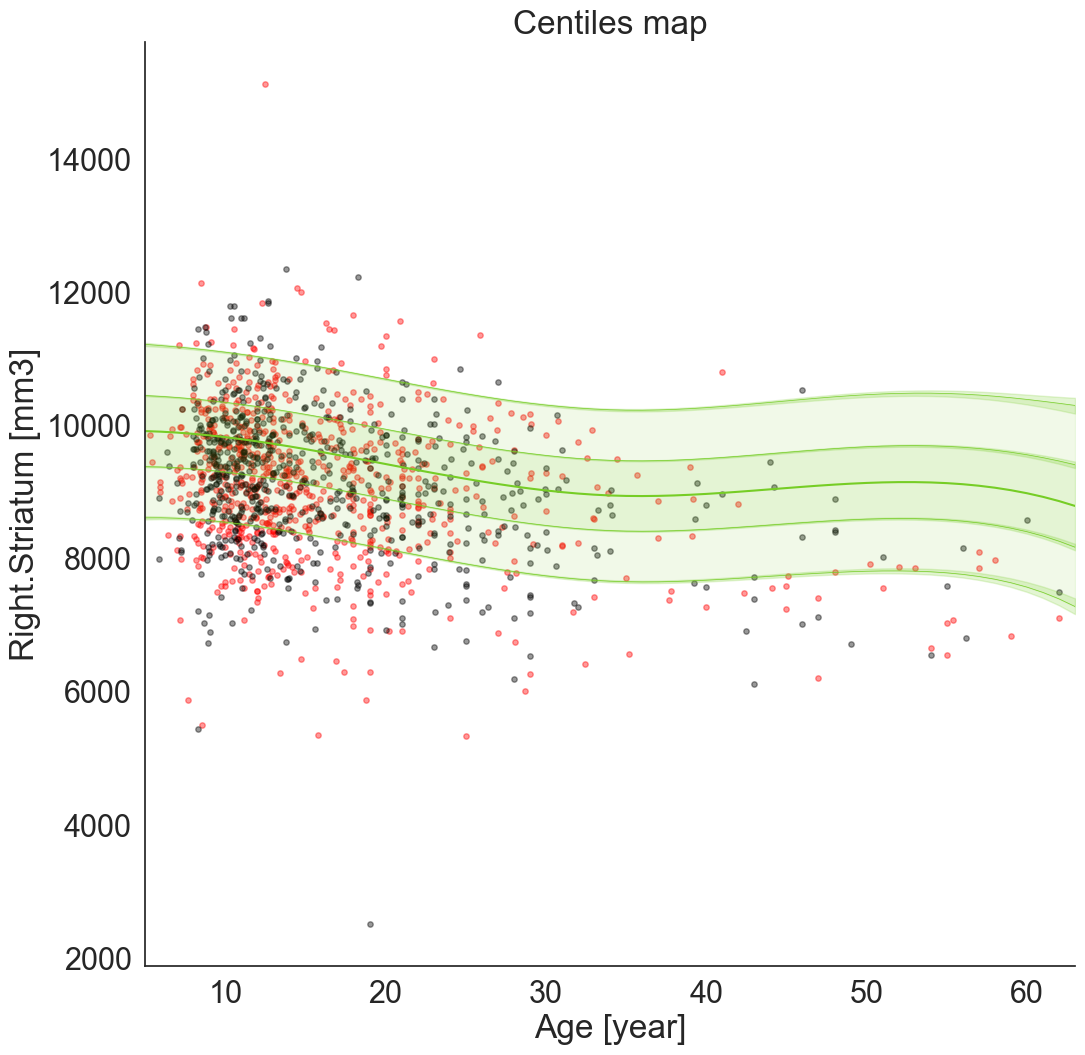

In [111]:
sets = ['te', 'tr'] #We plot both test and train in the plot so here define names of the sets.

##### Function to get only the ROI name ####

def hyphen_split(a):
    if a.count("_") == 1:
        return a.split("_")[0]
    return "_".join(a.split("_", 2)[:2])


# Use a function to load the data since PCNtoolkit needs a specific format. Lets load this function
def load_2d(filename):
    """ this simple function loads a data type supported by PCNtoolkit and
        ensures that the output is a 2d numpy array
    """
    
    x = fileio.load(filename)
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    
    return x


##### Plot #####

for idp_num, idp in enumerate(roi_ids): #loop through ROIs
    
    # Set style of plots
    sns.set(style='dark')
    
    #Set path to folder of ROI
    idp_dir = os.path.join(params['out_dir'],idp)
    os.chdir(idp_dir)
    
    
    for wset in sets: #Loop through both test and train so we can plot both in one
                
#Load data centriles

        #Load X_te and X_tr
        X_te = load_2d(os.path.join(idp_dir, 'cov_bspline_' + wset + '.txt'))
        
        #Load results 
        results = pd.DataFrame()
        results['Z score'] = np.loadtxt(os.path.join(os.path.join(out_dir, idp),'Z_'+ wset +'.txt')).copy()
        
        #Load the carriers data points
        yhat_te = load_2d(os.path.join(idp_dir, 'yhat_' + wset + '.txt'))
        s2_te = load_2d(os.path.join(idp_dir, 'ys2_' + wset + '.txt'))
        y_te = load_2d(os.path.join(idp_dir, 'resp_' + wset + '.txt'))
        
        #Load the normative model
        with open(os.path.join(idp_dir,'Models', 'NM_0_0_'+ suffix + '.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 
            
            
#Creaty dummy matrix

        xx = np.arange(params['xmin'], params['xmax'])
        
        X0_dummy = np.zeros((len(xx), len(params['cols_cov'])))
        X0_dummy[:,0] = xx
        X0_dummy[:,1] = np.mean(all_data['FIQ'])
        X0_dummy[:,2] = np.mean(all_data['meanEULER'])
        X0_dummy[:,3] = np.mean(all_data['EstimatedTotalIntraCranialVol'])
        
        # create the design matrix
        X_dummy = create_design_matrix(X0_dummy, 
                                       xmin=params['xmin'], 
                                       xmax=params['xmax'], 
                                       site_ids=None, 
                                       all_sites=params['site_ids'],
                                       basis = params['basis'],
                                       nknots = params['nknots'])

        # save the dummy covariates
        cov_file_dummy = os.path.join(params['out_dir'],'cov_bspline_dummy_mean_' + '.txt')
        np.savetxt(cov_file_dummy, X_dummy) 
        
       
#Set up covariates for the dummy data

        # set up the covariates for the dummy data
        print('Making predictions with dummy covariates (for visualisation)')
        yhat, s2 = predict(cov_file_dummy, 
                            alg = params['algo'], 
                            respfile = None, 
                            model_path = os.path.join(idp_dir,'Models'),
                            warp = params['warp'], warp_reparam = params['warp'] is not None, 
                            outputsuffix = '_dummy_')
    
        
#Warping
        
    
        # get the warp parameters
        W = nm.blr.warp
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        # first, we warp predictions for the true data and compute evaluation metrics
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
        
        print('metrics:', evaluate(y_te, med_te))

        # then, we warp dummy predictions to create the plots
        med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

# extract the different variance components to visualise
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
        s2n = 1/beta # variation (aleatoric uncertainty)
        s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

        
#Set parameters for plot

        params_plot = {  'med' : med,
                'yhat' : yhat,
                'W' : W,
                'warp_param': warp_param,
                's2' : s2,
                's2s' : s2s,
                'xx' : xx,
                'idp' :  idp, 
                'idp_dir' : idp_dir,  
             }
        
        
#Resclae y_te
        
        y_te_rescaled = y_te.copy()
        y_te_rescaled = y_te - np.median(y_te) + np.median(med)

# Plot the data not per site 

        # Set style for plot
        sns.despine()
        plt.rc('figure', figsize=(12, 12))
        sns.set(font_scale=2, style="white")

        
        #Set colors for sets
        if wset == 'te':
            color = 'red'
        else:
            color = 'black'
        
        #Scatter plot
        plt.scatter(X_te[:,1], y_te_rescaled, s=15, color=color, alpha = 0.4)
        
    plt.plot(params_plot['xx'], params_plot['med'], '#76cd26')
    
    
#Go through all centriles and fill in between centriles

    for percentiles in [[0.25,0.75], [0.05,0.95]] :#, [0.01,0.99]] :
        # fill the gaps in between the centiles
        junk, pr_int = params_plot['W'].warp_predictions(np.squeeze(params_plot['yhat']), np.squeeze(params_plot['s2']), params_plot['warp_param'], percentiles=percentiles)
        plt.fill_between(params_plot['xx'], pr_int[:,0], pr_int[:,1], alpha = 0.1, color='#76cd26')

        # make the width of each centile proportional to the epistemic uncertainty
        junk, pr_intl = params_plot['W'].warp_predictions(np.squeeze(params_plot['yhat']), np.squeeze(params_plot['s2']-0.5*params_plot['s2s']), params_plot['warp_param'], percentiles=percentiles)
        junk, pr_intu = params_plot['W'].warp_predictions(np.squeeze(params_plot['yhat']), np.squeeze(params_plot['s2']+0.5*params_plot['s2s']), params_plot['warp_param'], percentiles=percentiles)
        plt.fill_between(params_plot['xx'], pr_intl[:,0], pr_intu[:,0], alpha = 0.2, color='#76cd26')
        plt.fill_between(params_plot['xx'], pr_intl[:,1], pr_intu[:,1], alpha = 0.2, color='#76cd26')

        # plot actual centile lines
        plt.plot(params_plot['xx'], pr_int[:,0],color='#76cd26', linewidth=0.5)
        plt.plot(params_plot['xx'], pr_int[:,1],color='#76cd26', linewidth=0.5)

          
        
    plt.xlabel('Age [year]')
    plt.ylabel(idp + ' [mm3]') 
    plt.xlim((params['xmin'],params['xmax']-1))

    plt.title('Centiles map')
    
    # Save plots in output directory.
    plt.savefig(os.path.join(params_plot['idp_dir'], '_centiles_' + params_plot['idp'] + '_adj_sites' +'.png'))
    plt.show()